# CS 3110 Final Project
## Ryan Symons + Harry Sharman

* In this projects we will be using a new data set - students.csv - which has columns such as GPA, student ID, email, etc., and we will be using laplace and guassian to keep differential privacy and analyze the results
* On a secondary discourse, we will look at how laplace and gaussian preform, and decide which is more efficient for our data set
* We included histograns to show a visual representation of our findings
* Lastly, we preformed an averaging attack using both sequential and advanced composition

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(qs, sensitivity, epsilon):
    return [laplace_mech(q, sensitivity, epsilon) for q in qs]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(qs, sensitivity, epsilon, delta):
    return [gaussian_mech(q, sensitivity, epsilon, delta) for q in qs]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

students = pd.read_csv('https://github.com/hsharman/cs3110_finalproj_hsharman_rsymons/blob/main/students.csv')

## Question 1 (5 points)

Implement the `dp_occupation_histogram` function below. It should return a differentially private histogram over the `Occupation` column in the `adult` dataset. Your function should have a total privacy cost of `epsilon` and should use parallel composition.

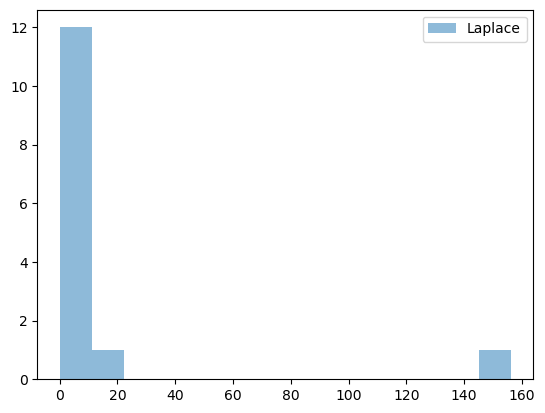

Occupation
Prof-specialty       4153.215219
Craft-repair         4089.635766
Exec-managerial      4070.621115
Adm-clerical         3754.379616
Sales                3662.322042
Other-service        3288.224704
Machine-op-inspct    1974.741447
Transport-moving     1592.203262
Handlers-cleaners    1387.938215
Farming-fishing       996.152107
Tech-support          938.127199
Protective-serv       679.979498
Priv-house-serv       180.108051
Armed-Forces           -5.056059
dtype: float64

In [2]:
def dp_occupation_histogram(epsilon):
    true_counts = adult['Occupation'].value_counts()
    
    num_bins = len(true_counts)
    
    sensitivity = 1.0
    
    epsilon_per_bin = epsilon / num_bins
    
    dp_counts = {
        occupation: laplace_mech(count, sensitivity, epsilon_per_bin)
        for occupation, count in true_counts.items()
    }
    
    dp_counts_series = pd.Series(dp_counts).reindex(true_counts.index, fill_value=0)
    
    laplace_error = pct_error(true_counts, dp_counts_series)

    plt.hist(laplace_error, bins=num_bins, label='Laplace', alpha=0.5)
    plt.legend()
    plt.show()
    
    return dp_counts_series  

dp_occupation_histogram(1.0)

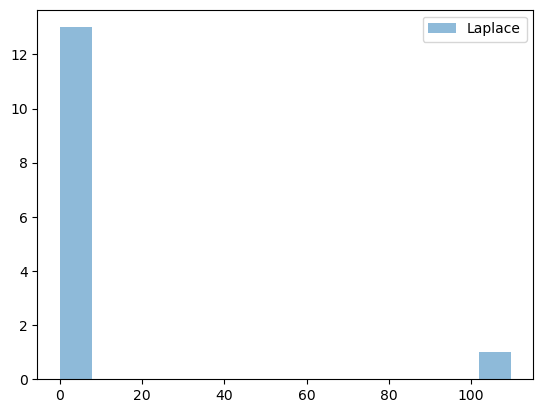

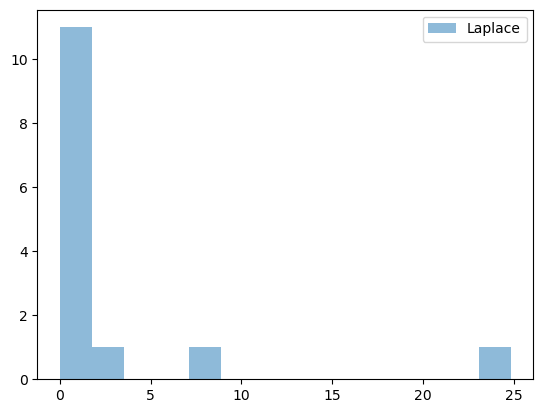

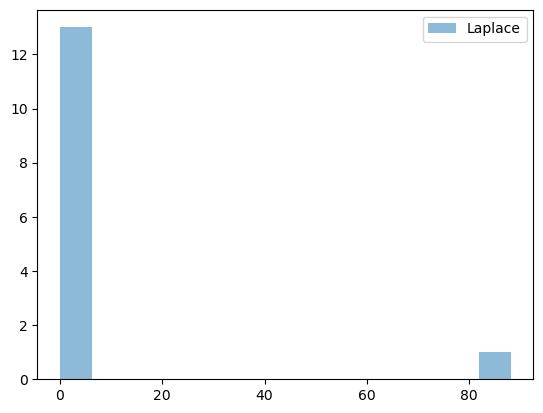

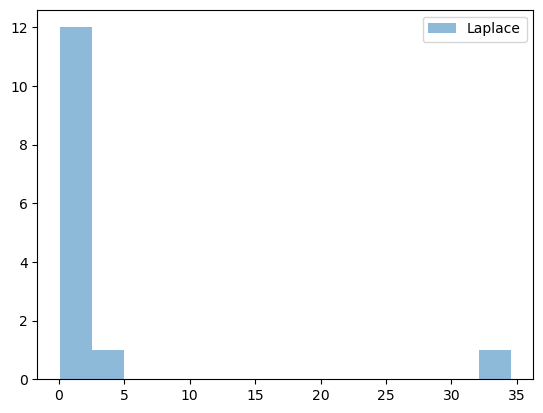

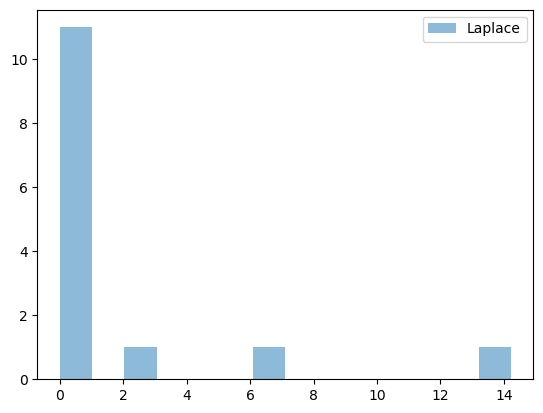

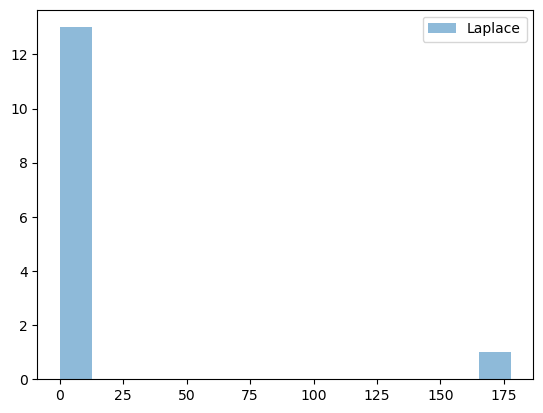

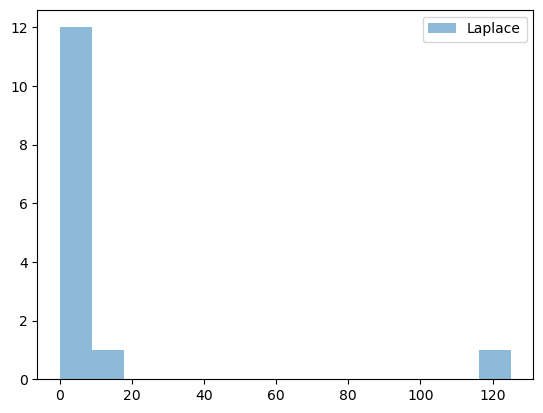

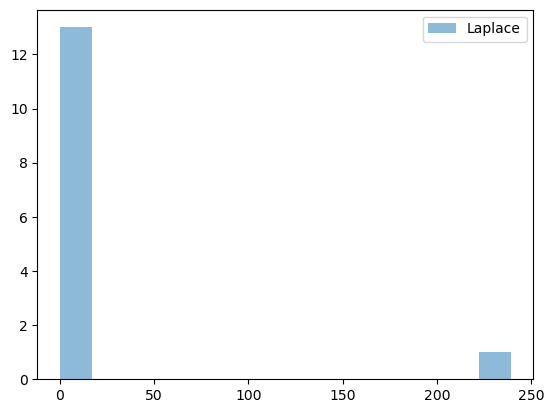

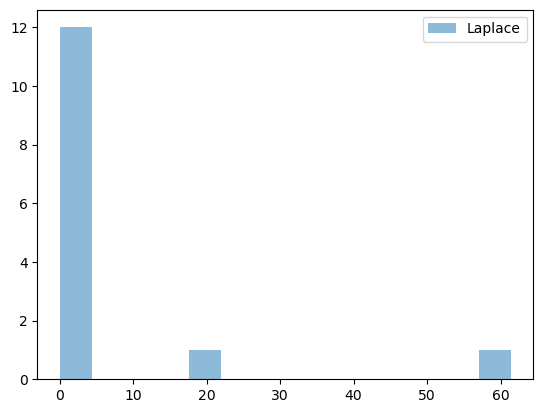

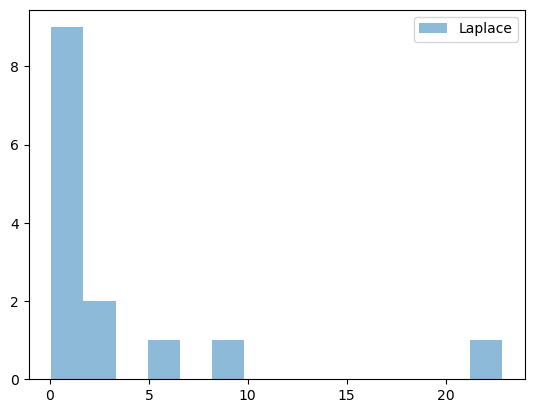

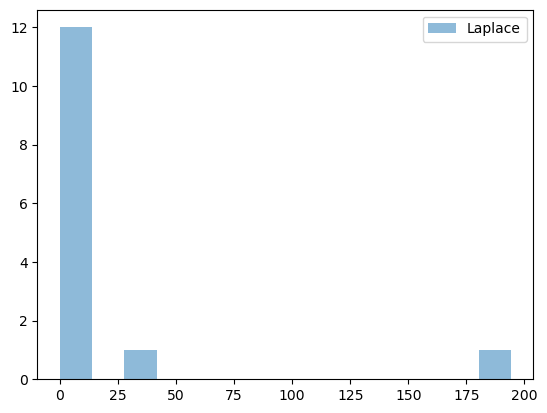

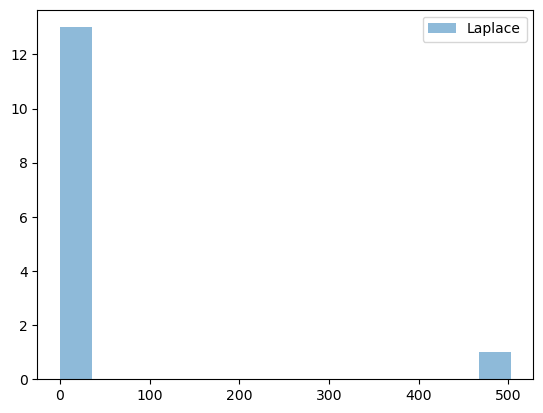

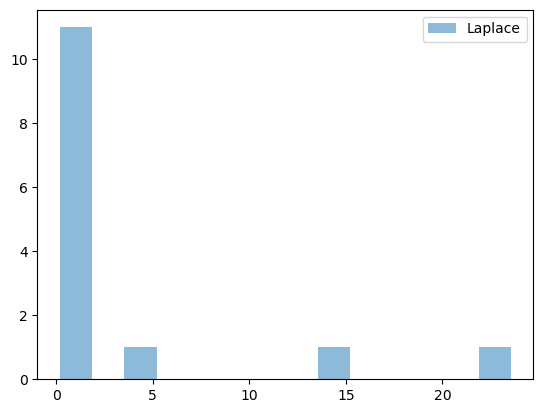

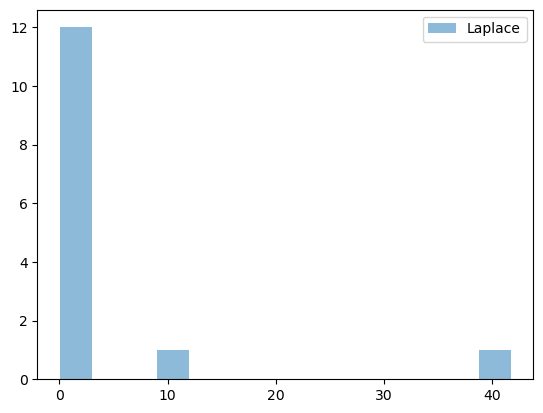

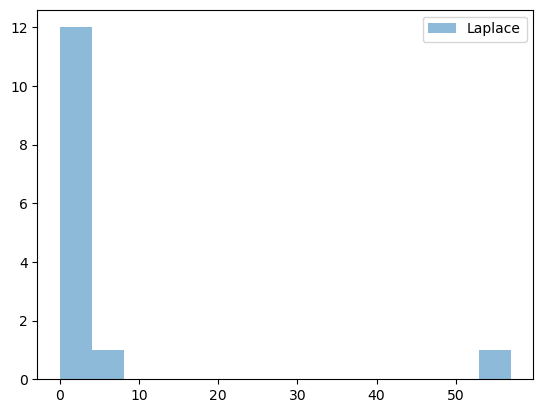

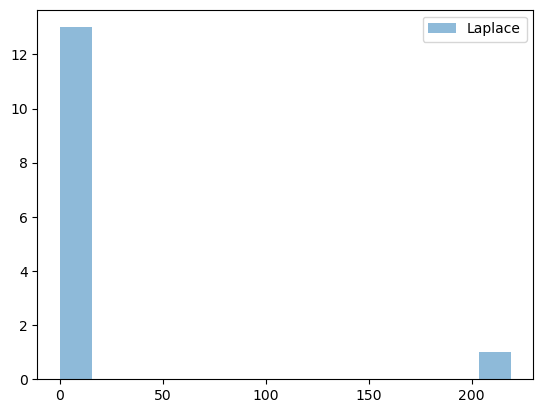

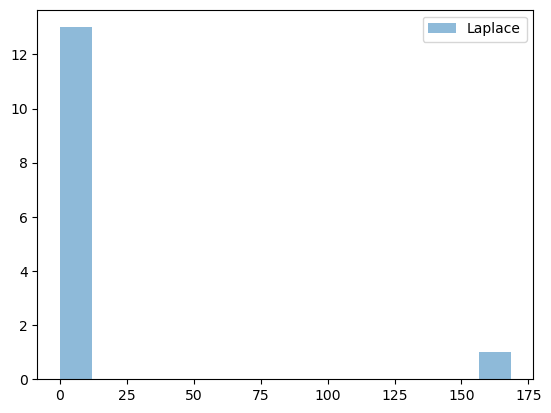

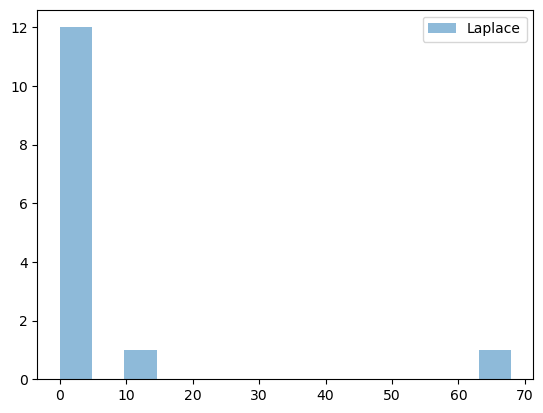

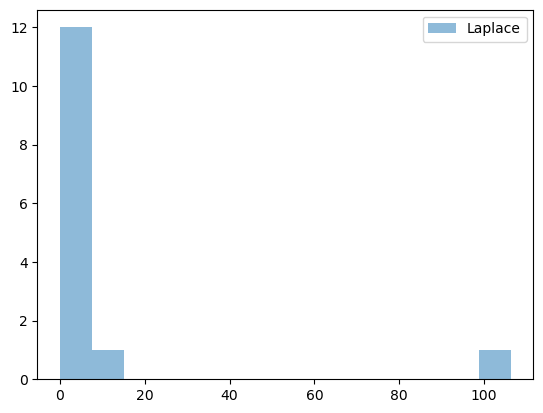

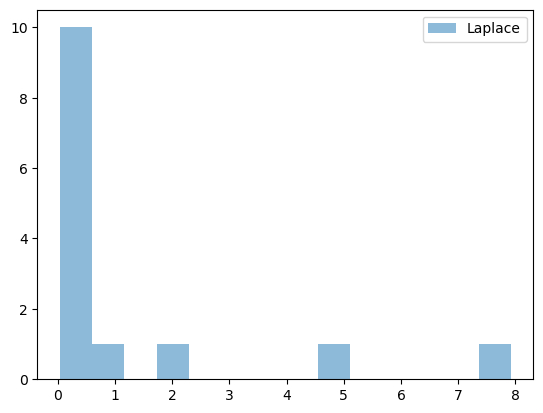

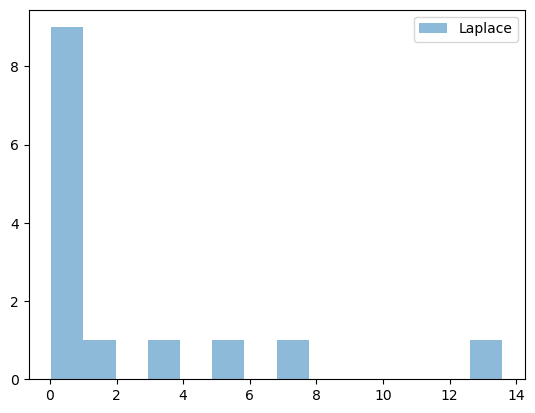

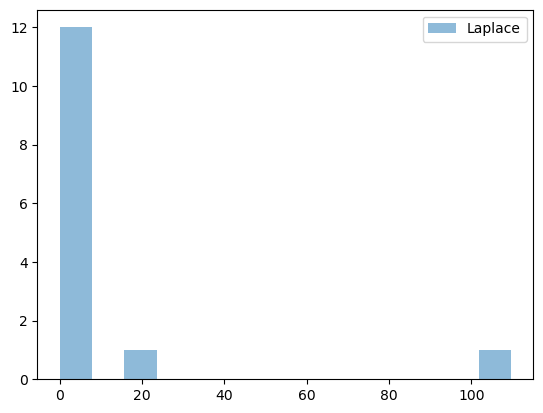

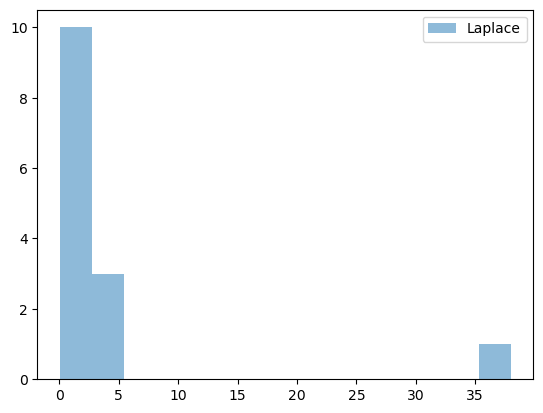

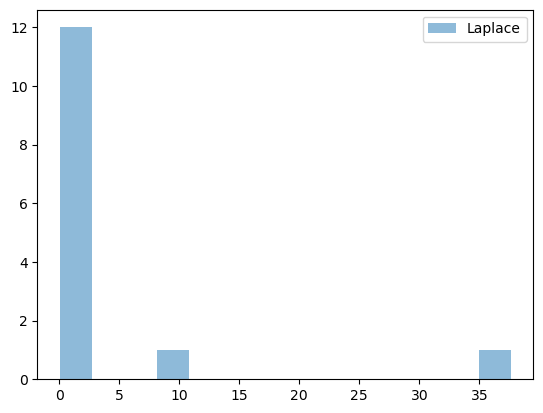

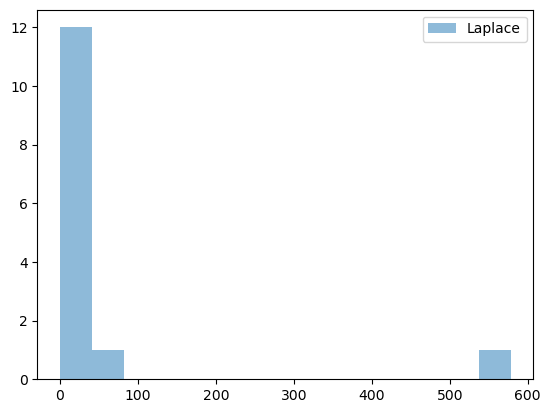

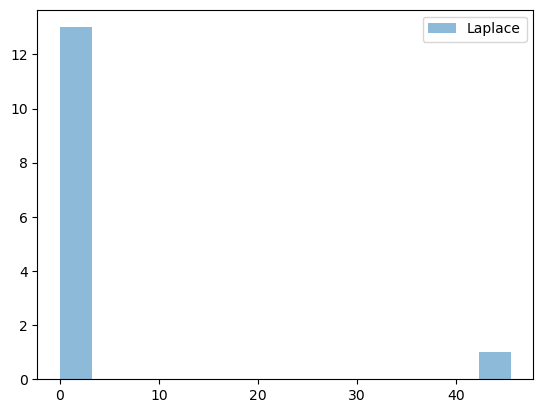

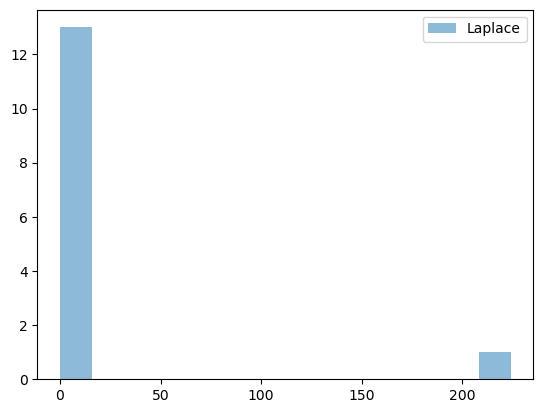

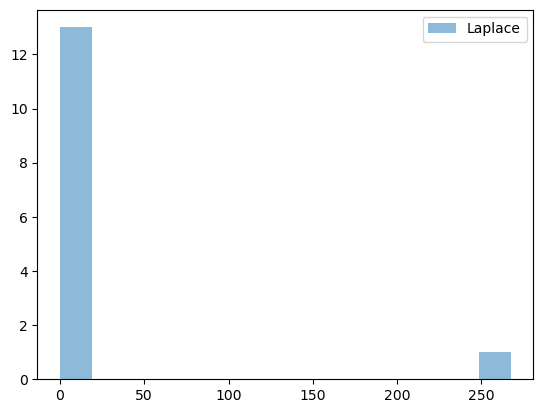

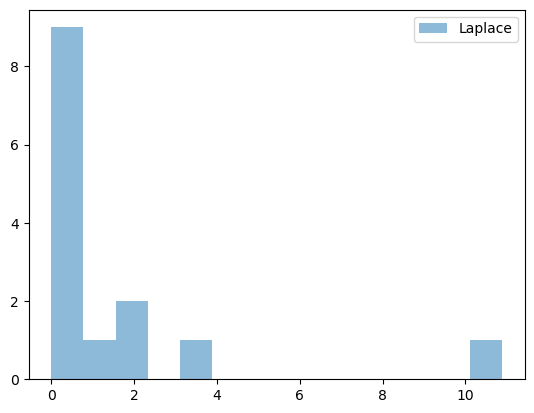

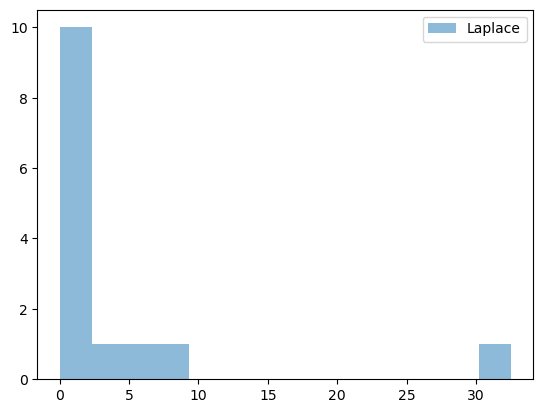

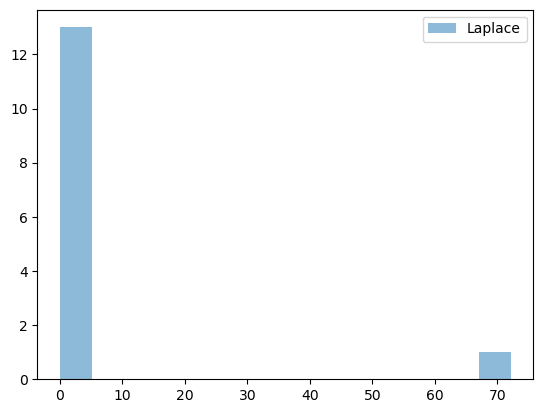

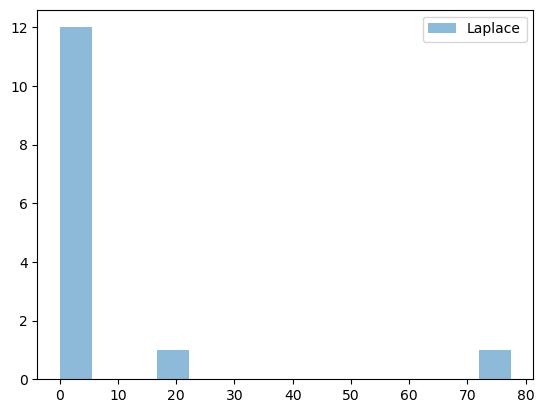

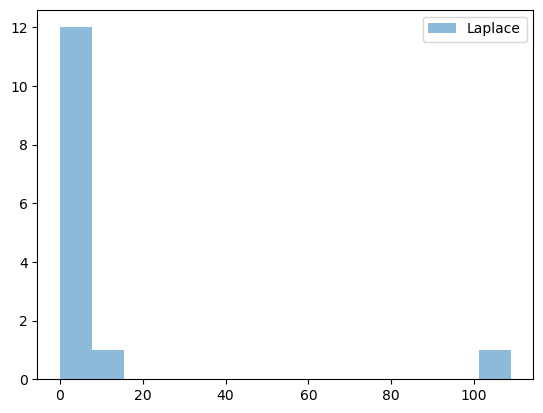

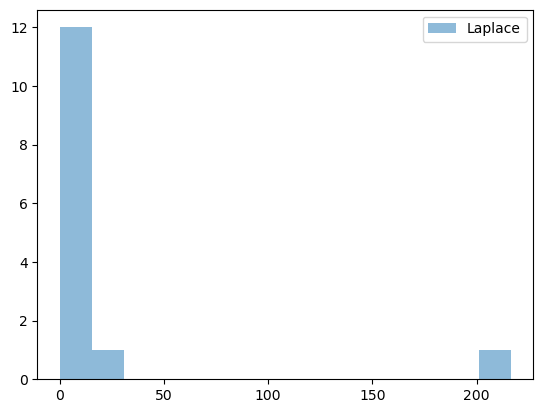

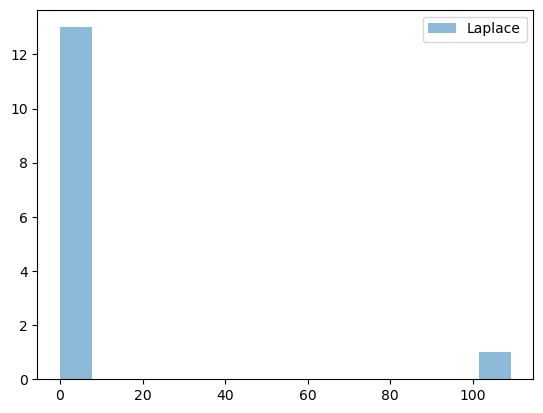

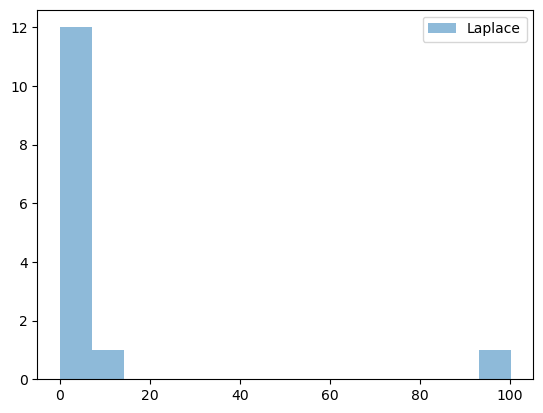

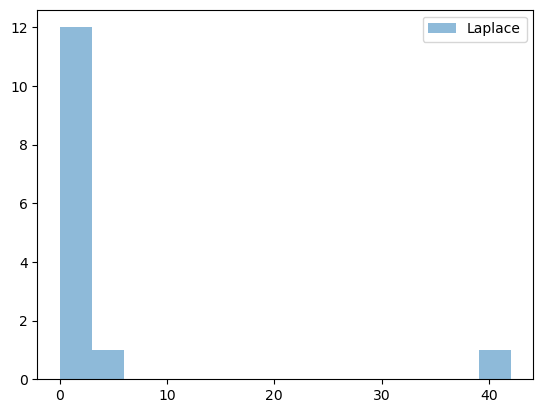

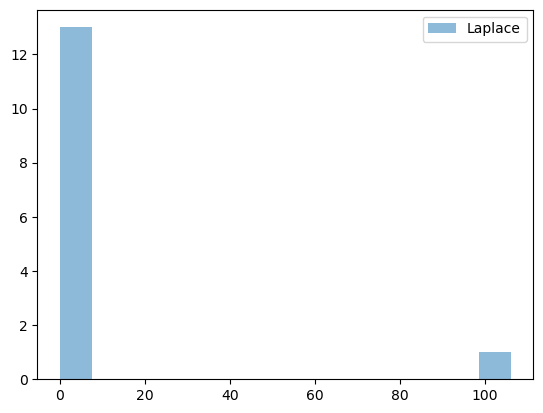

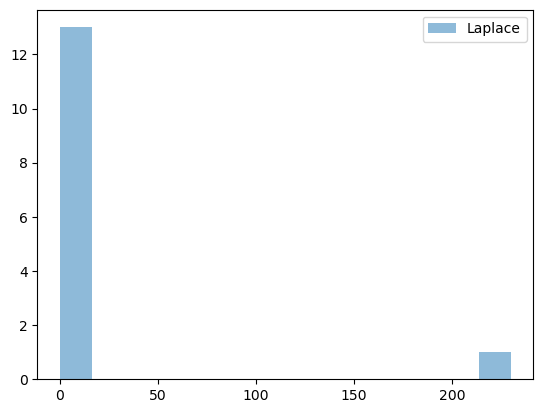

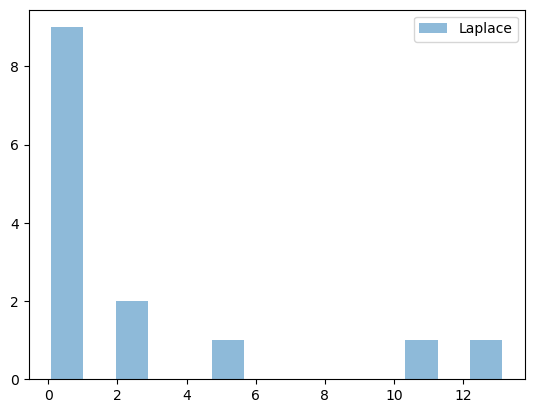

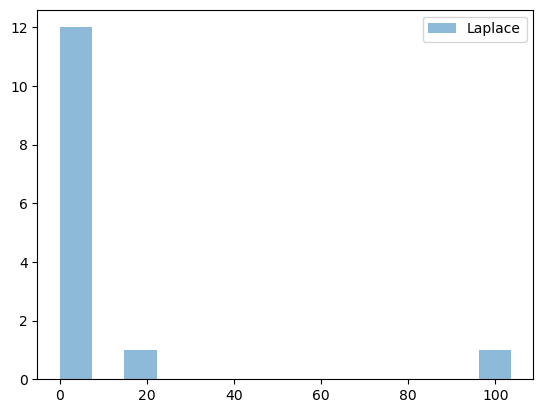

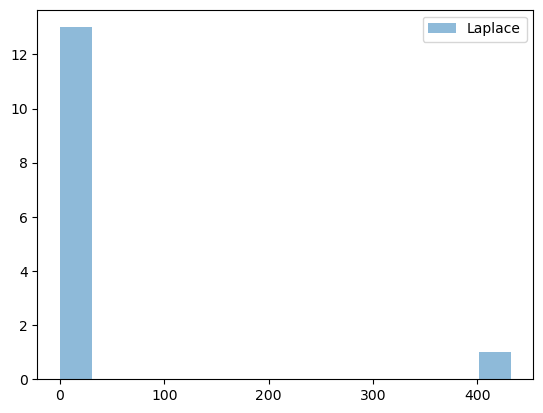

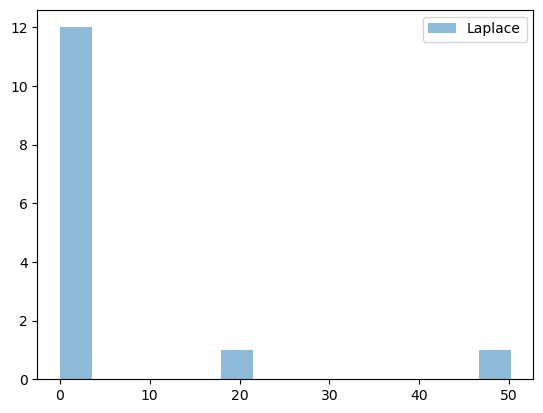

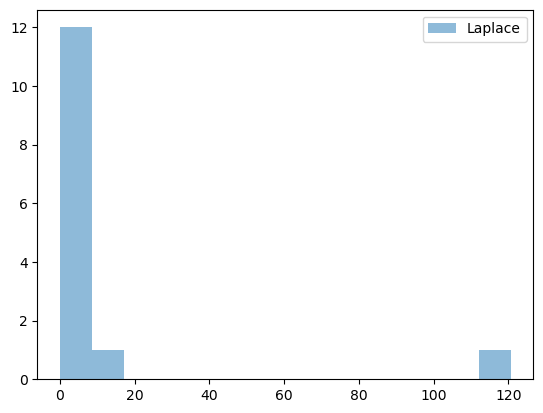

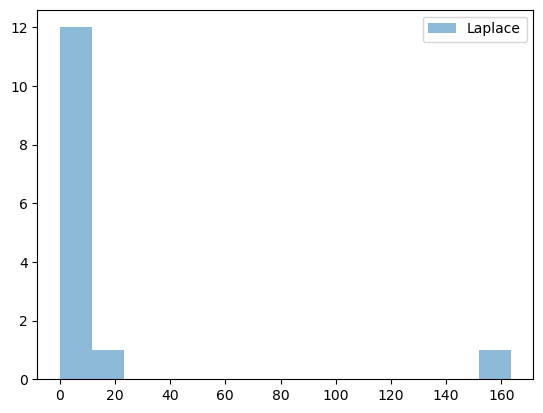

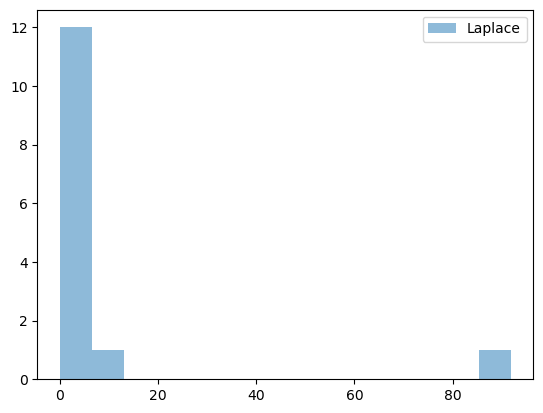

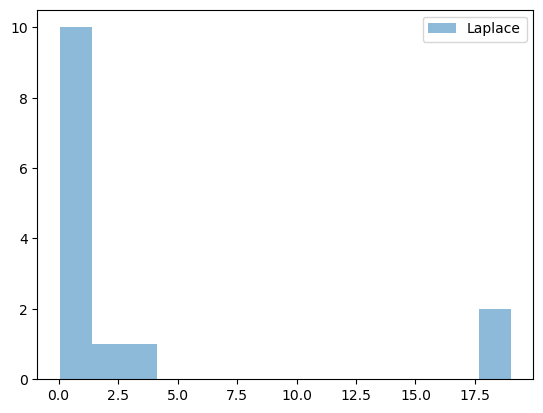

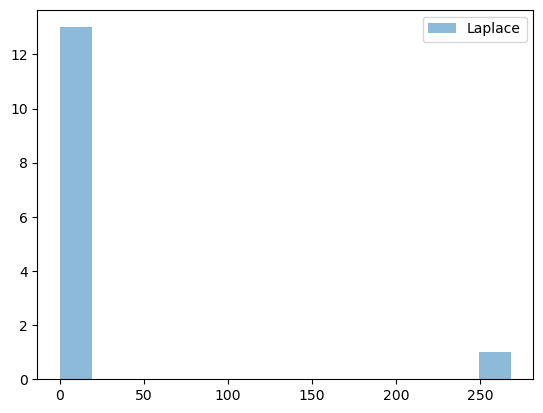

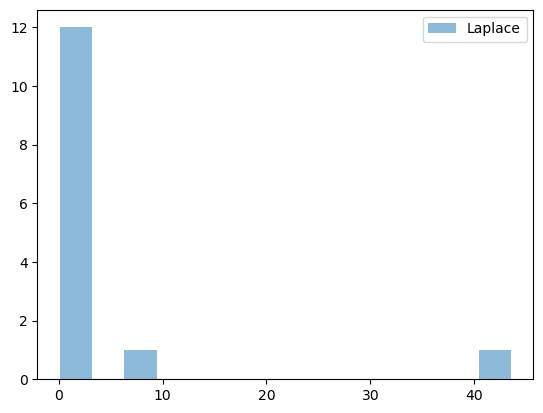

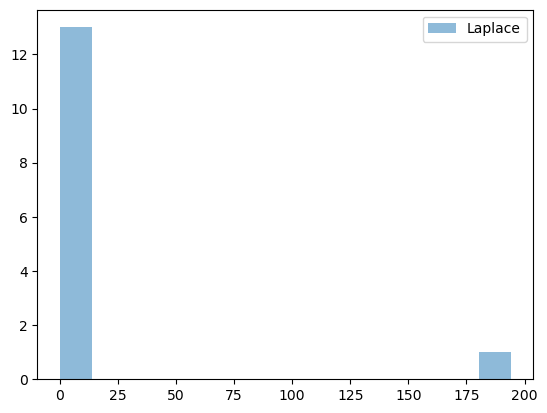

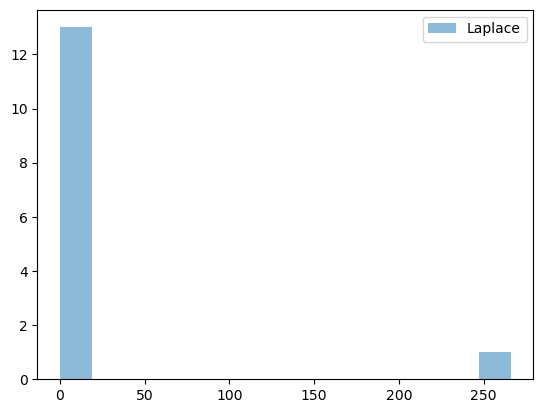

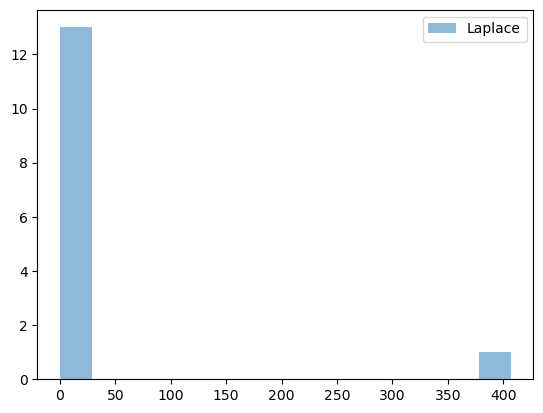

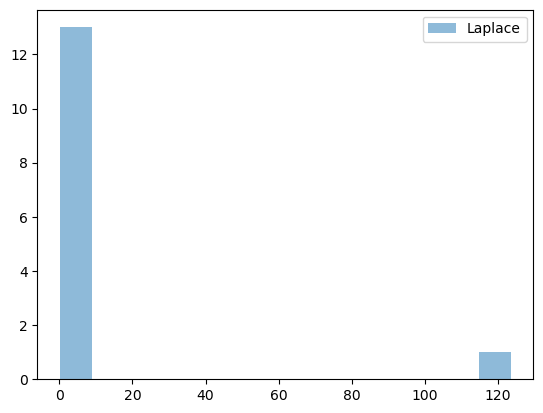

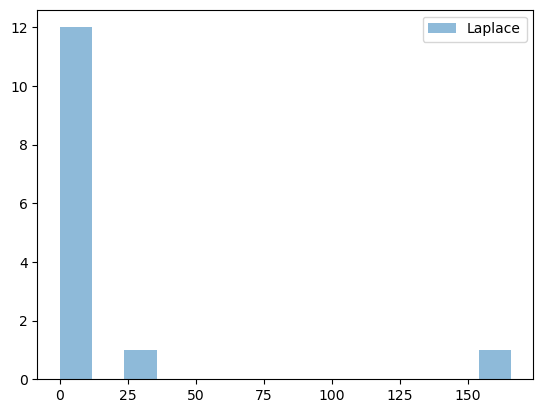

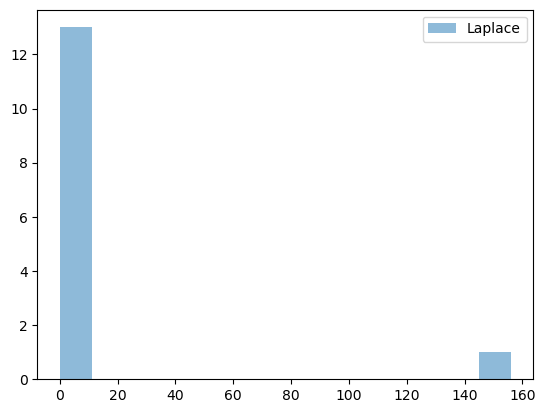

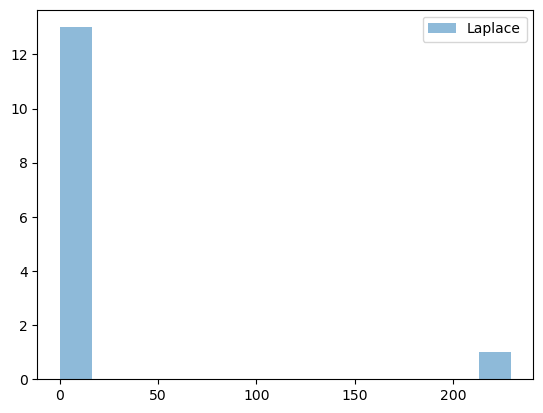

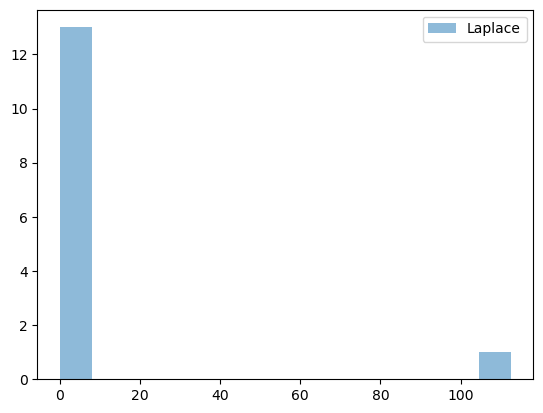

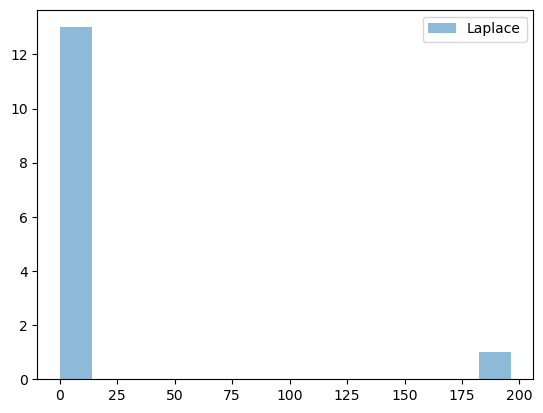

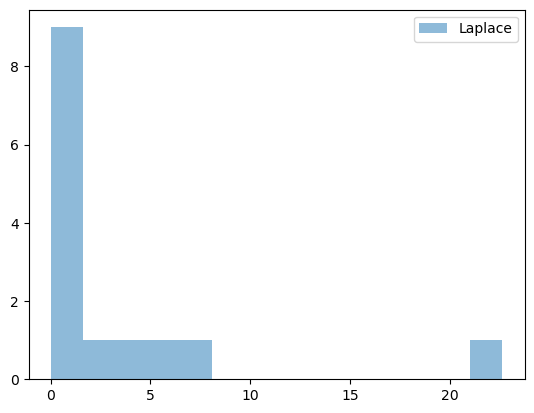

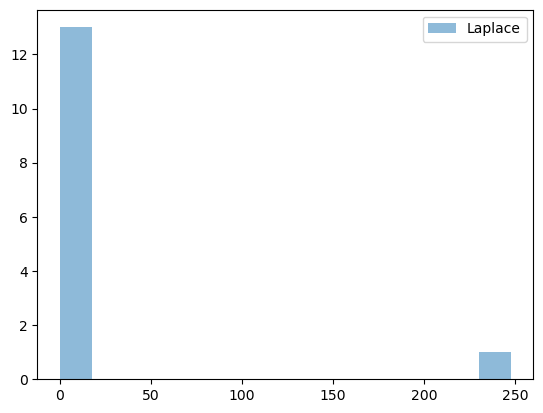

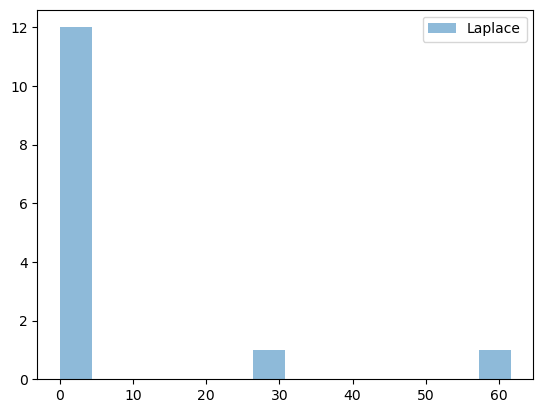

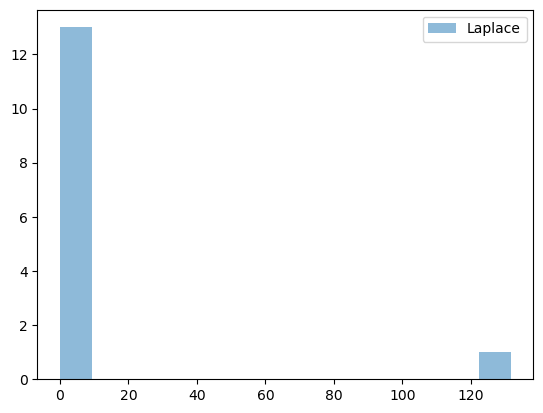

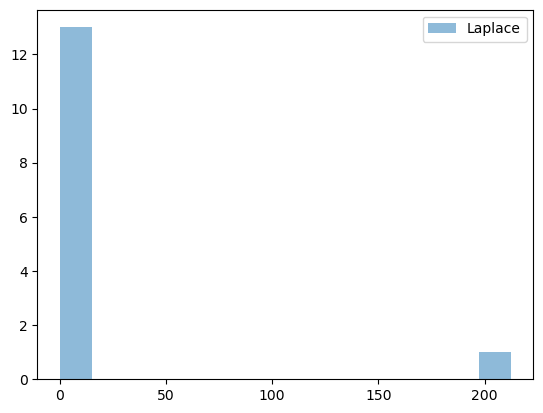

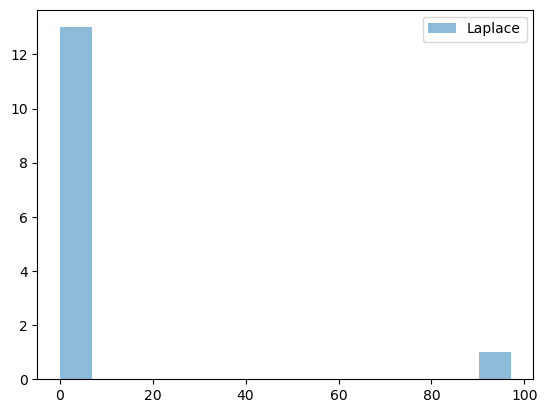

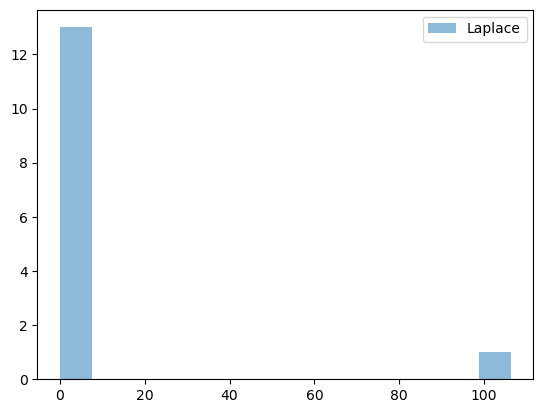

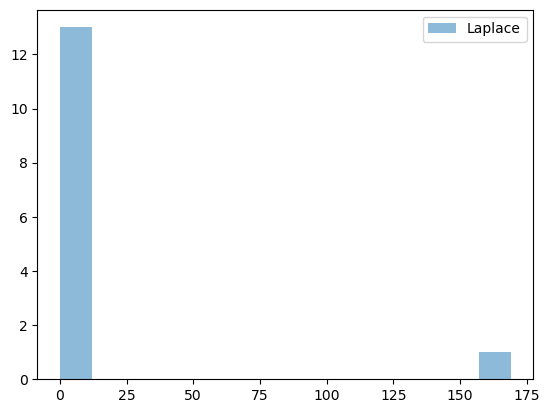

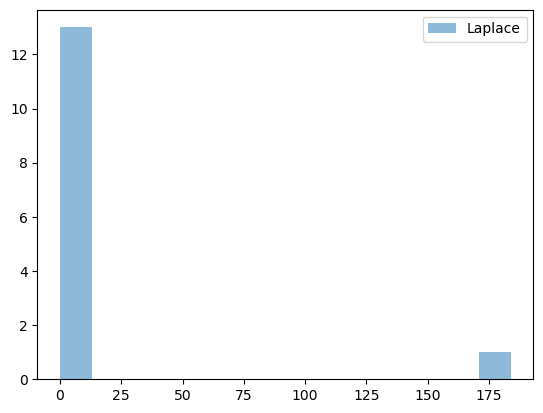

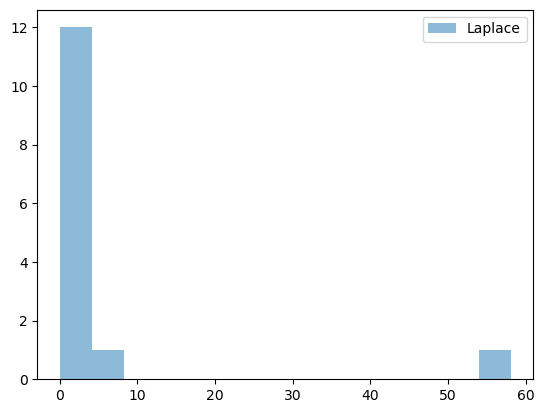

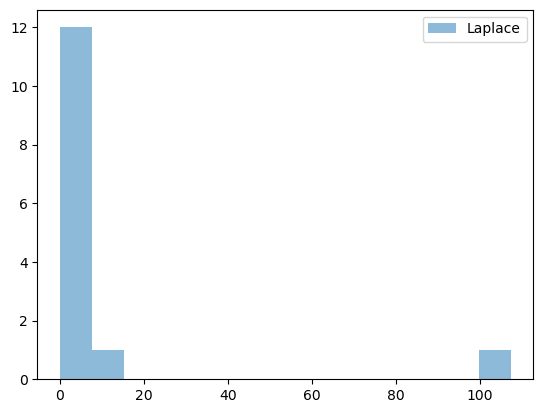

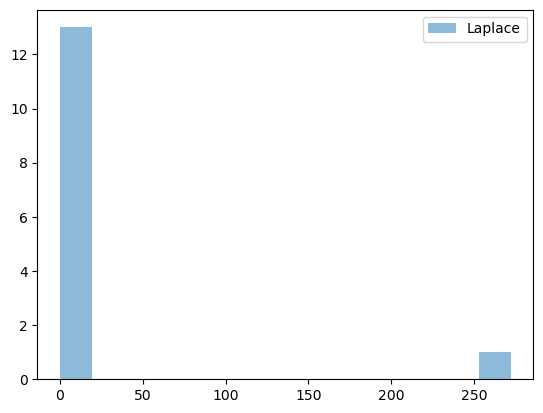

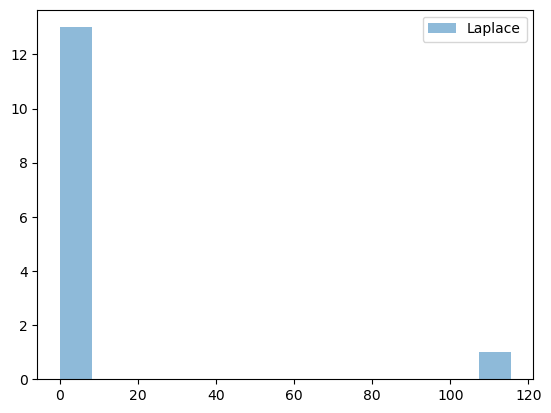

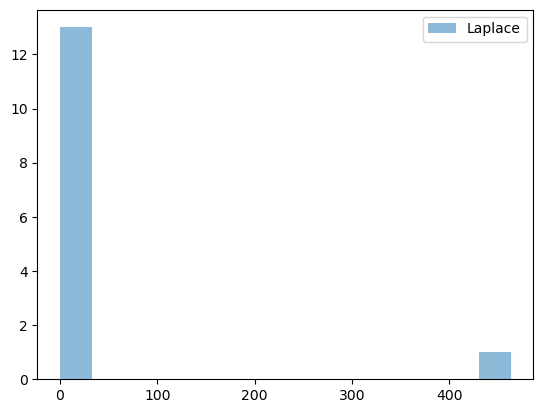

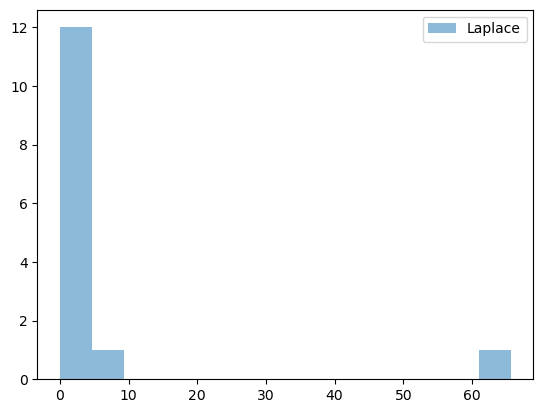

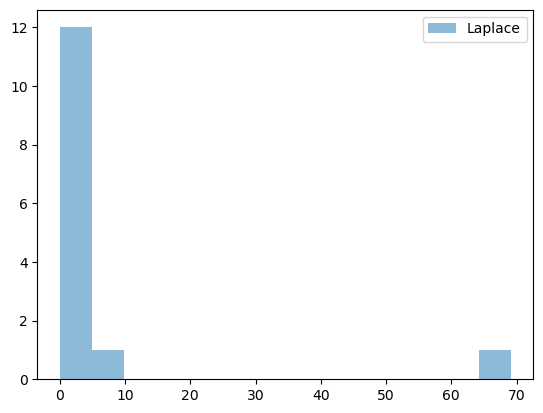

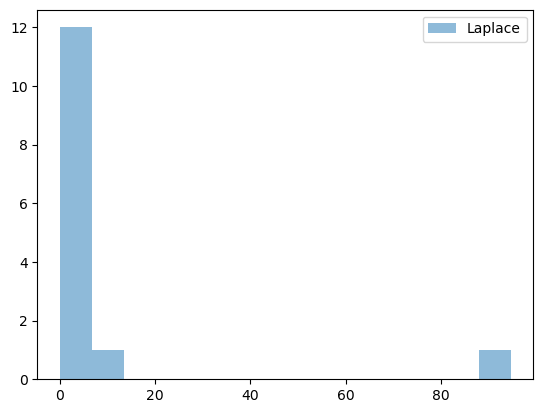

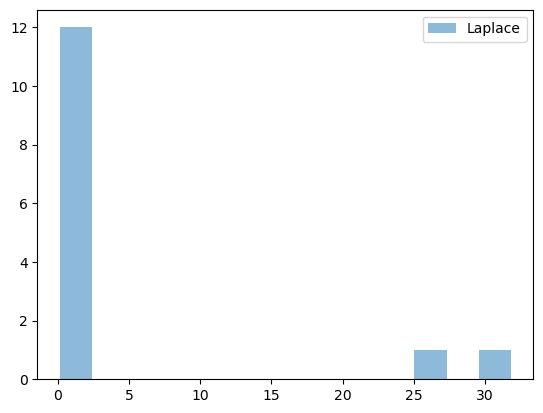

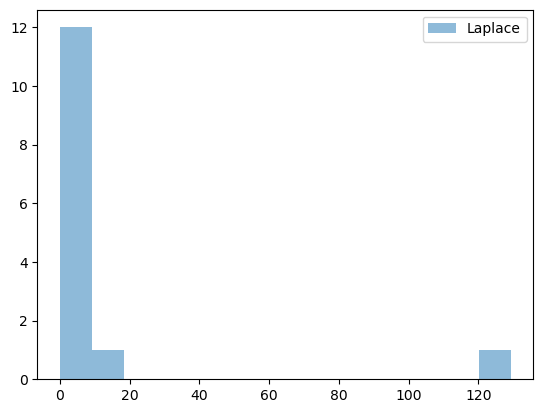

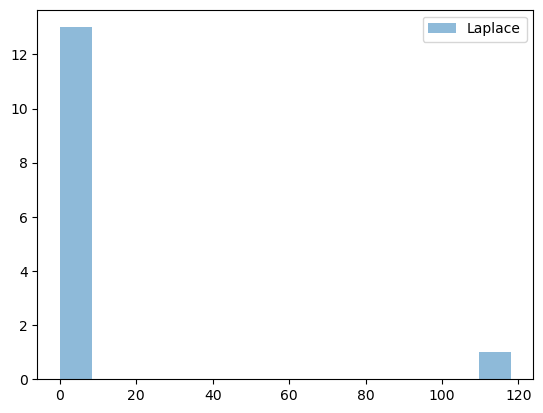

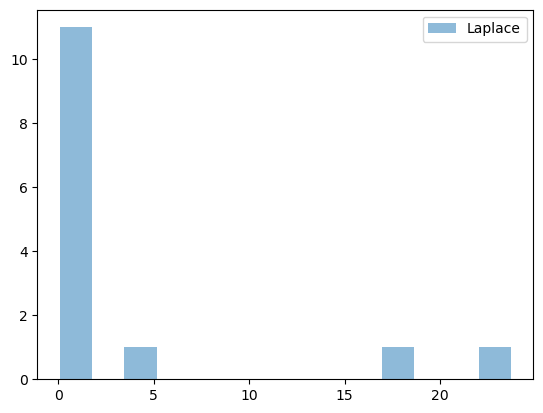

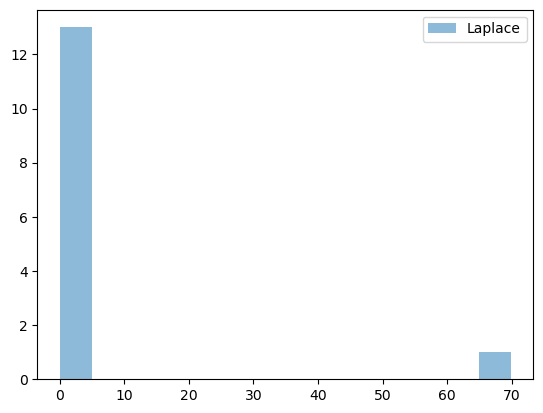

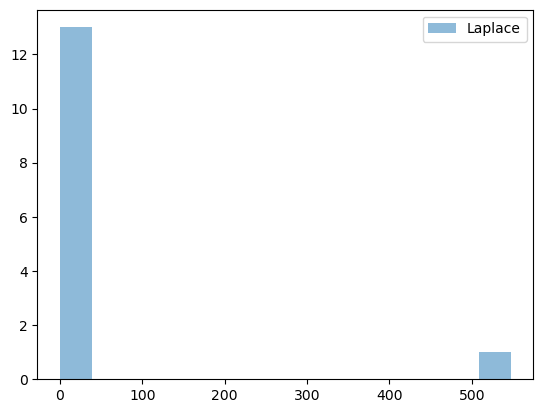

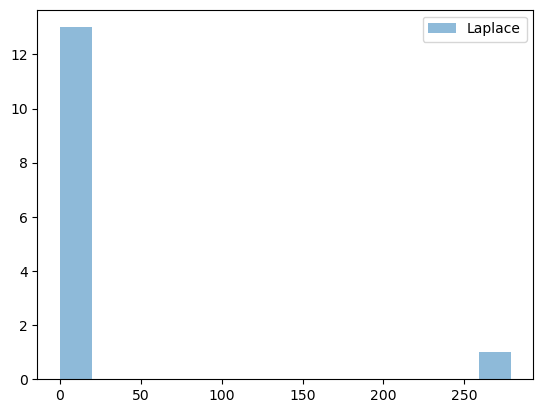

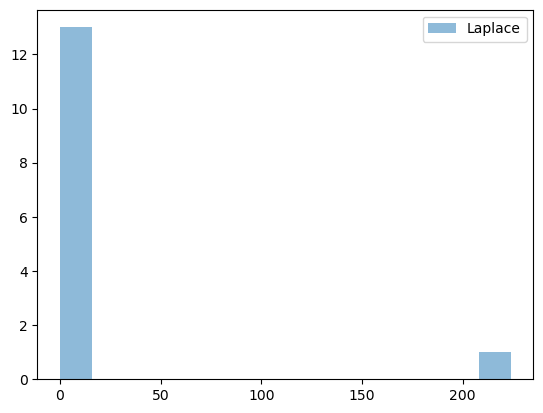

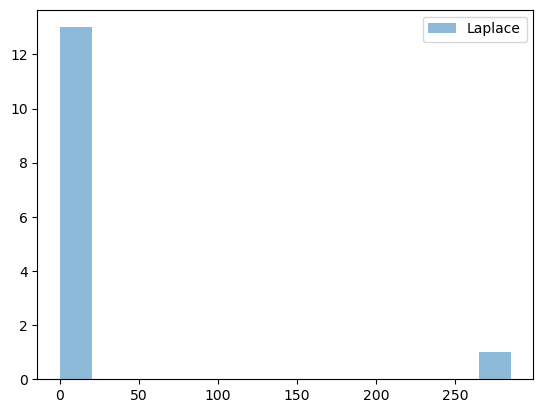

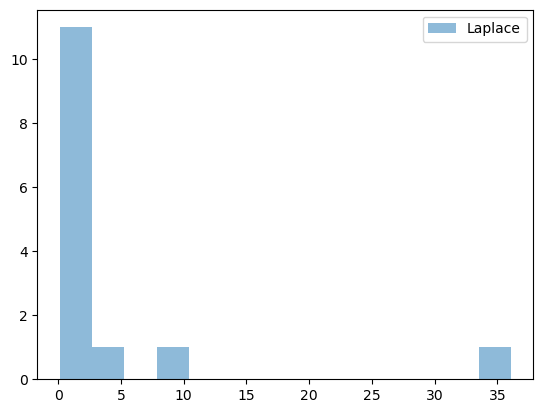

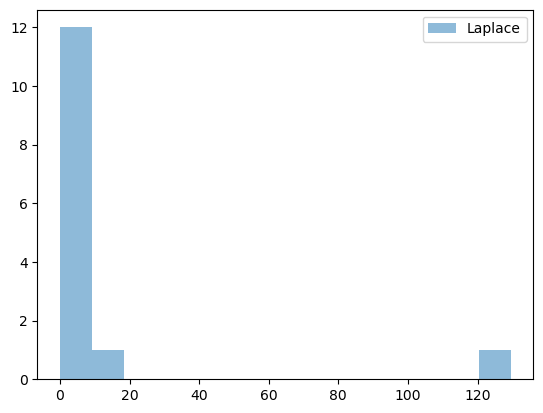

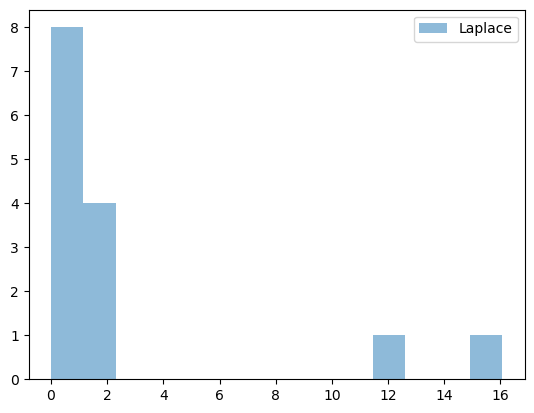

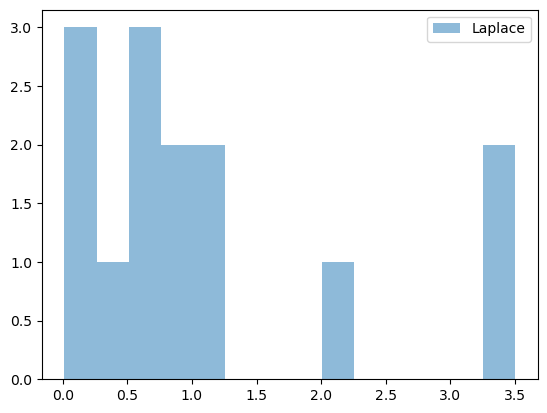

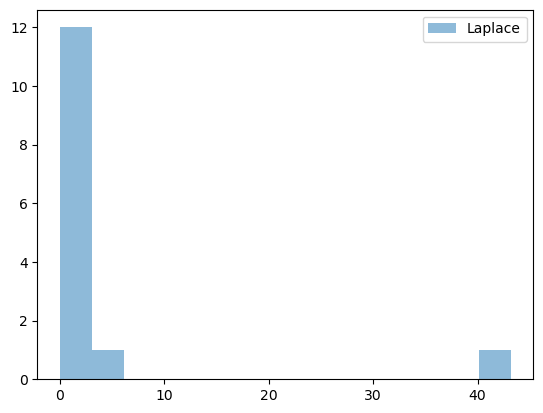

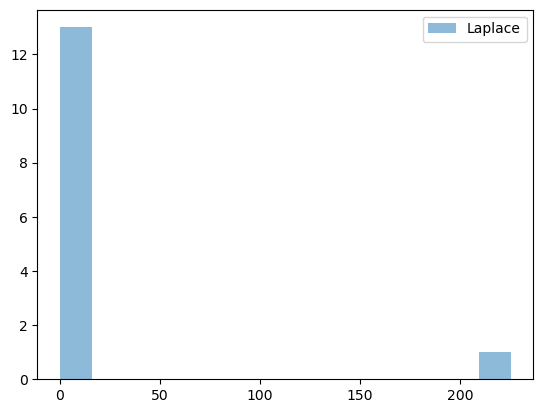

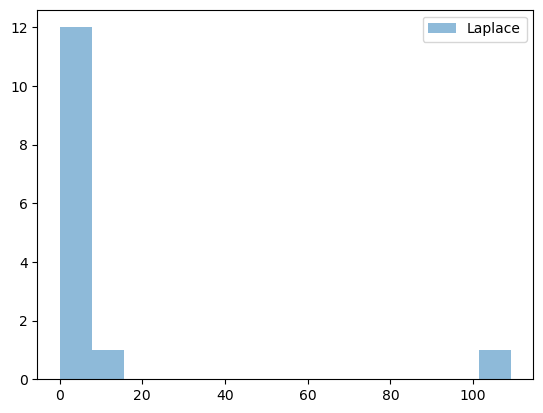

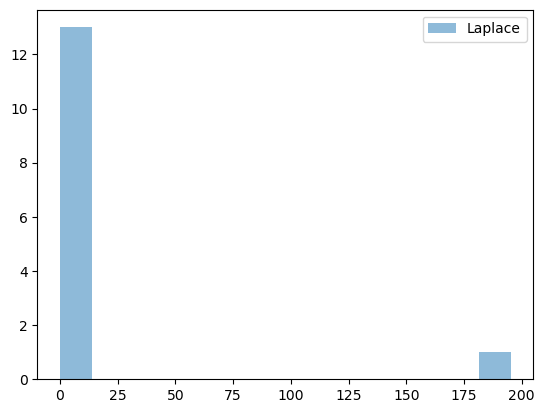

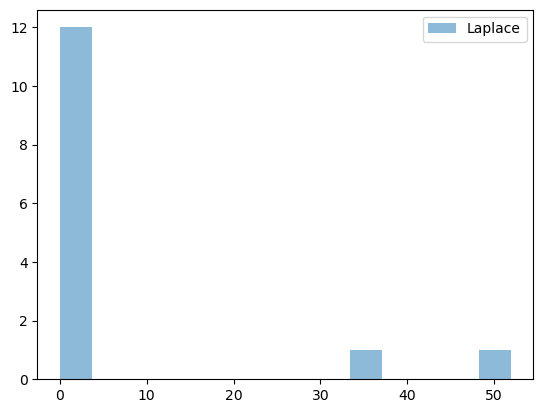

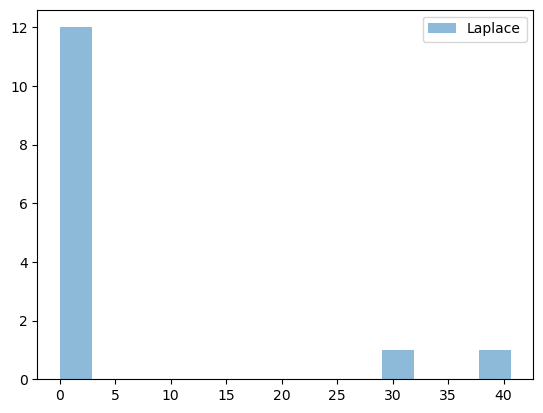

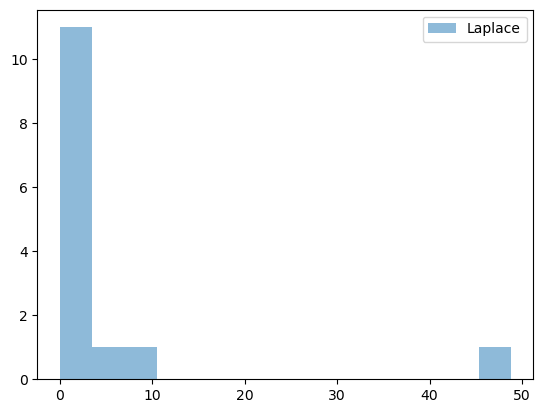

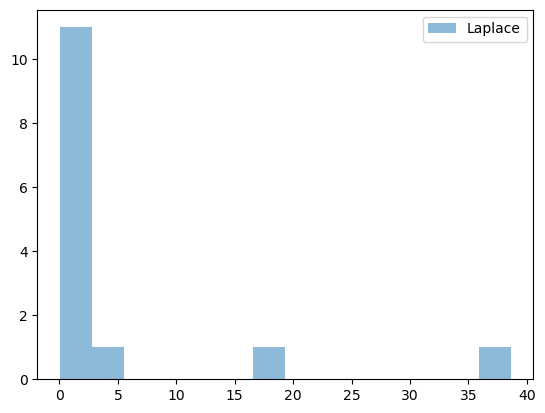

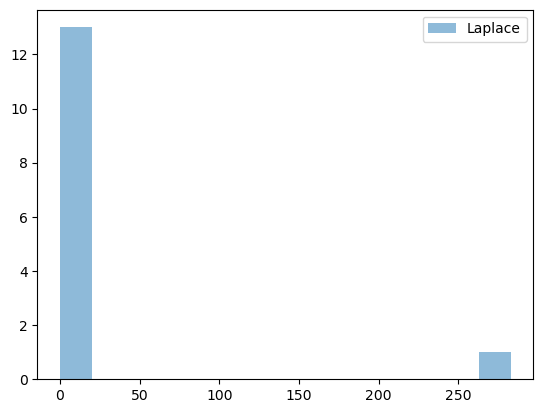

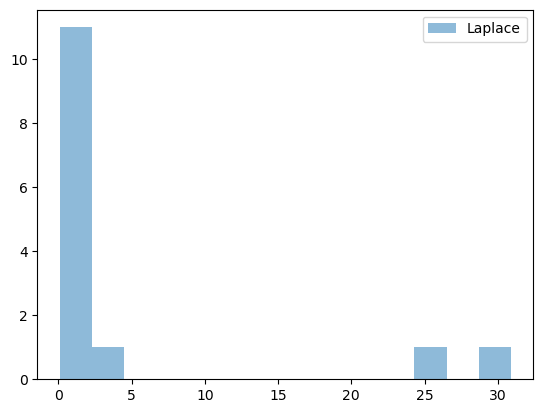

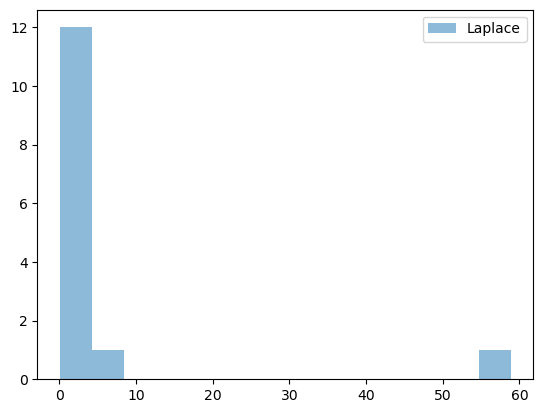

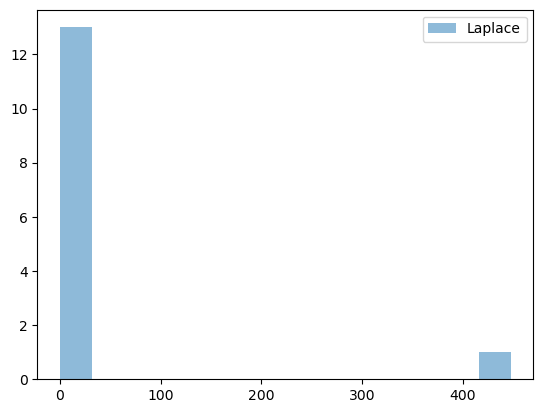

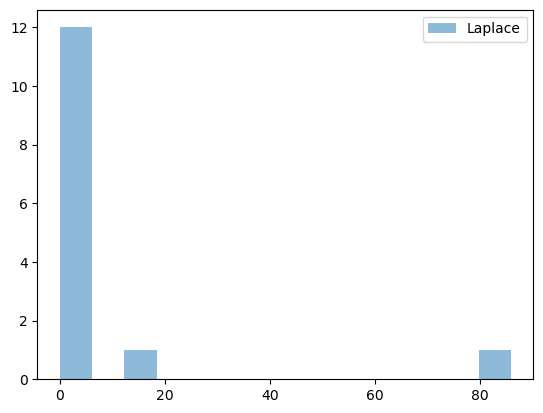

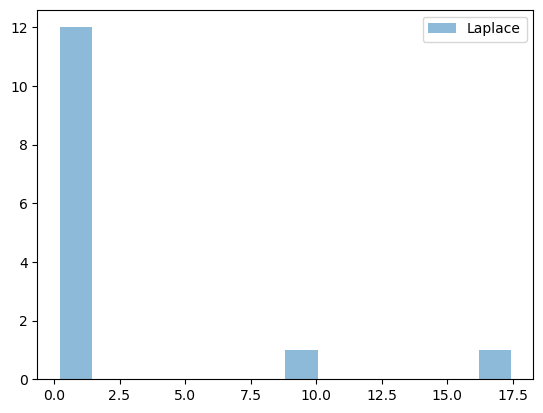

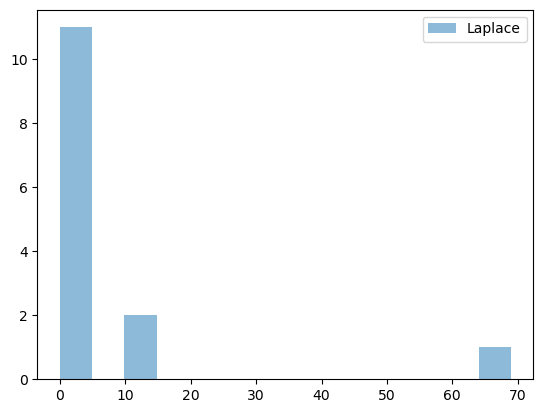

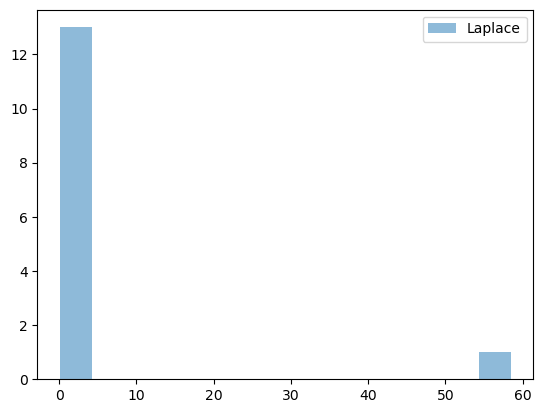

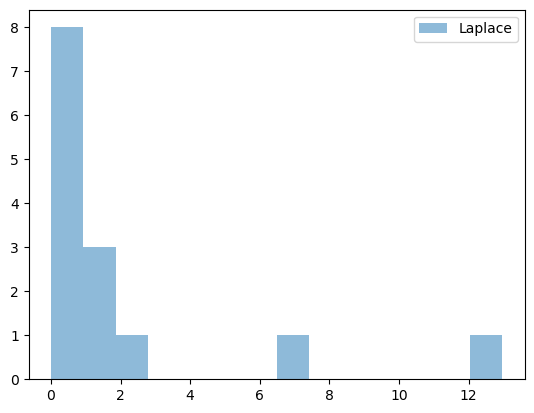

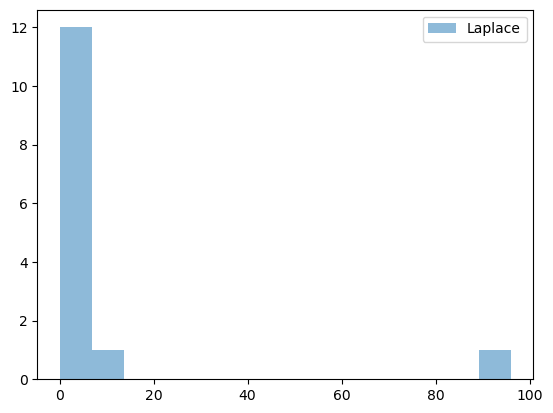

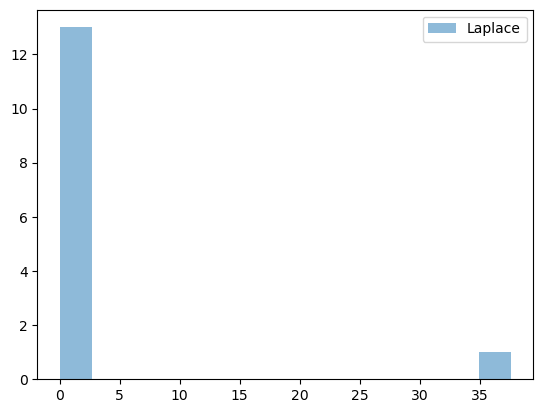

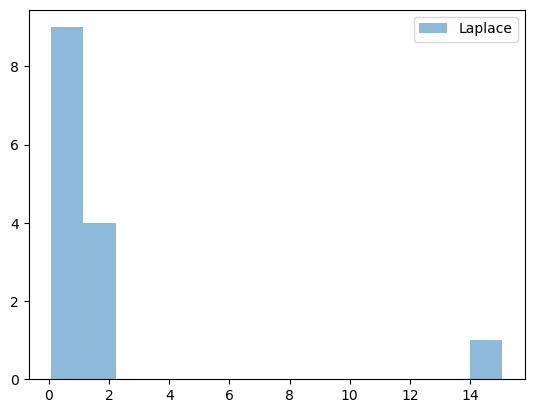

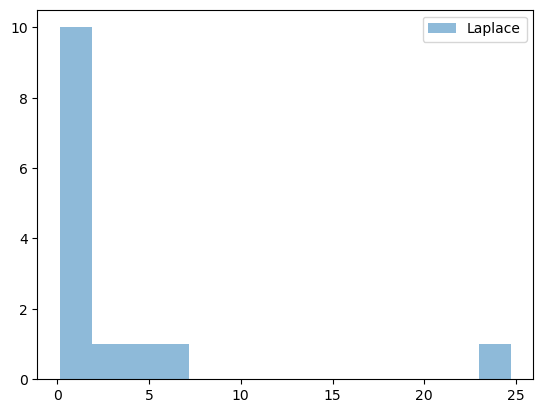

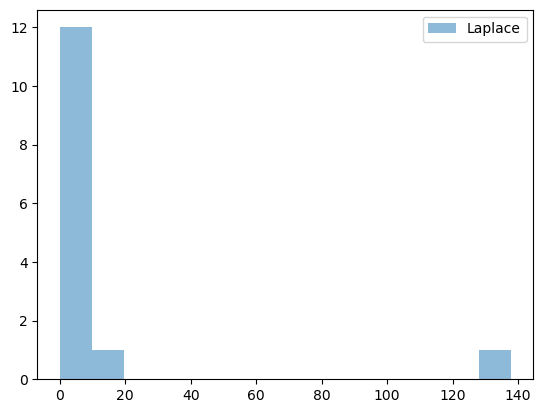

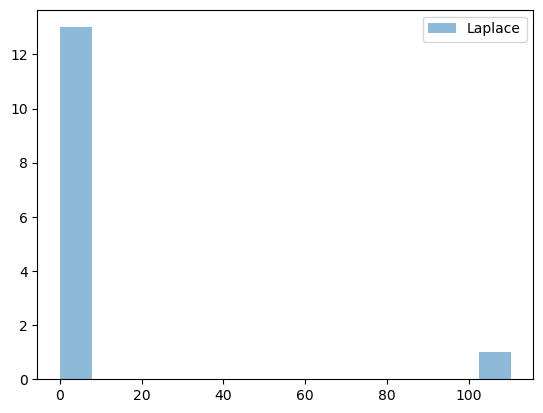

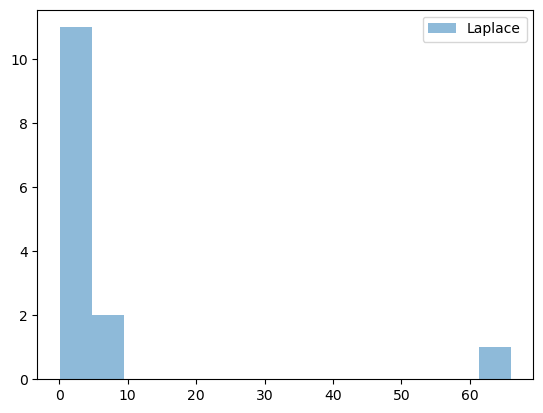

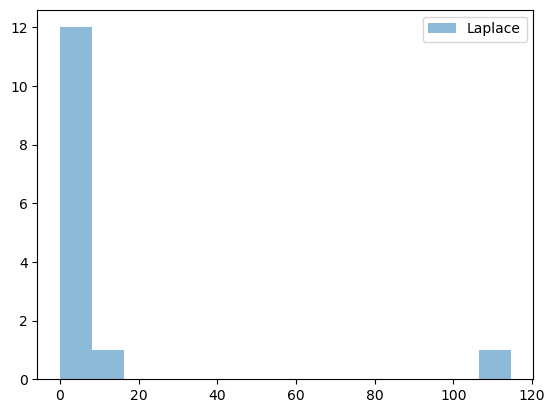

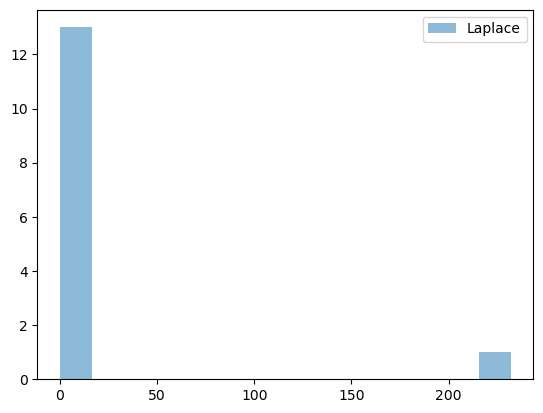

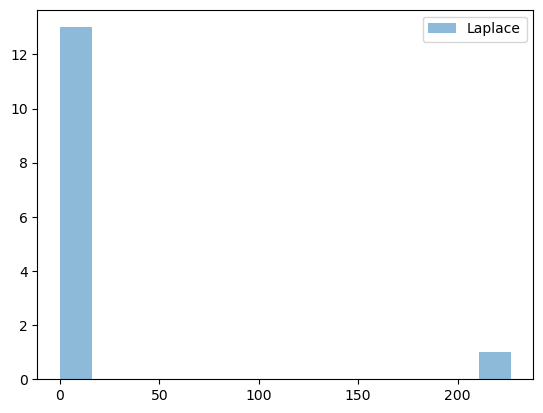

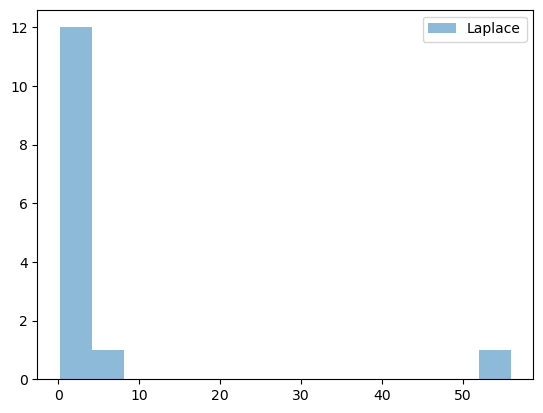

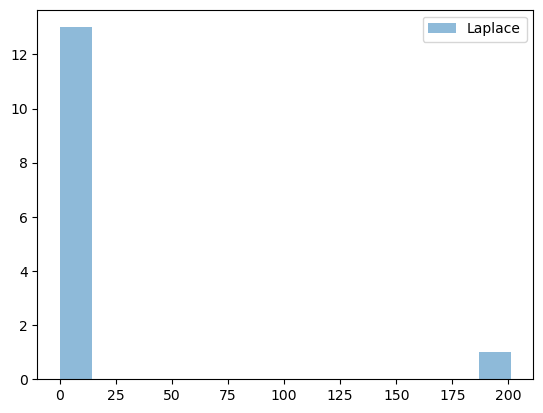

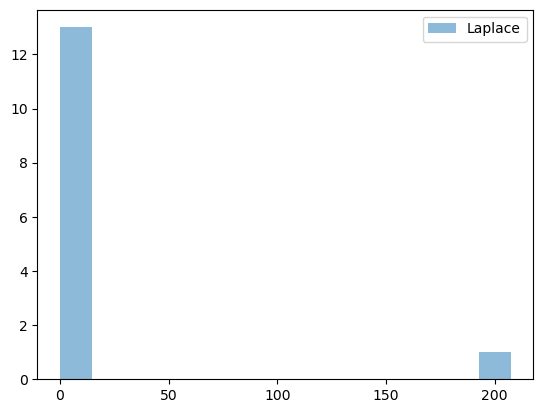

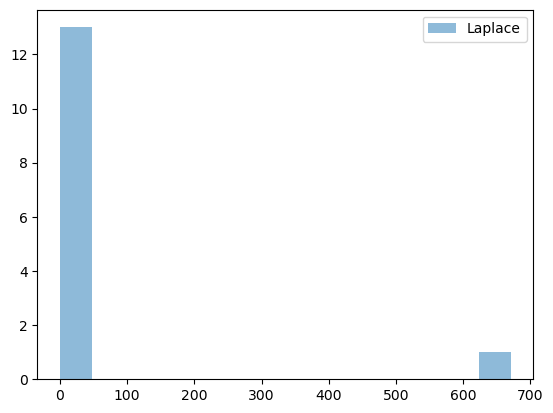

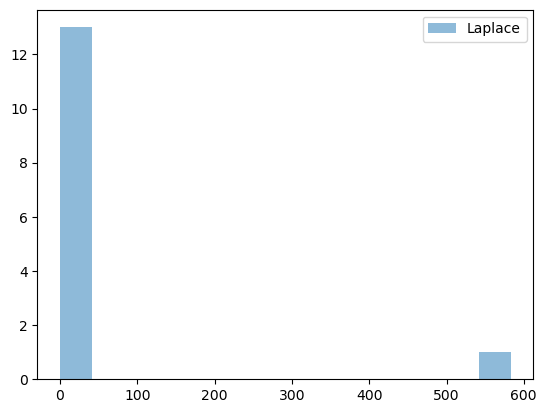

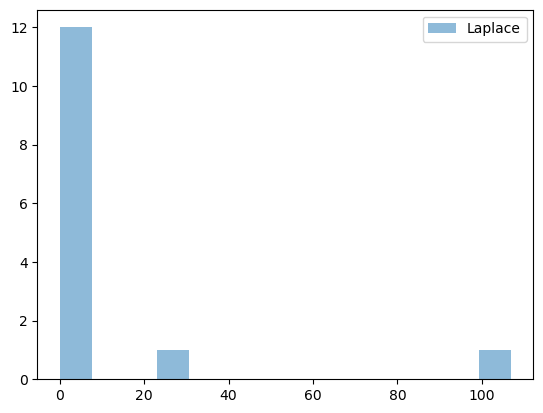

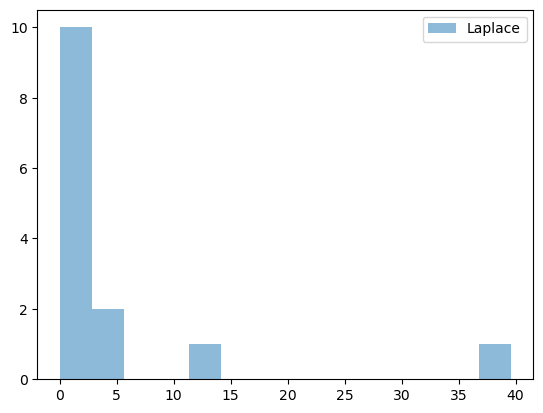

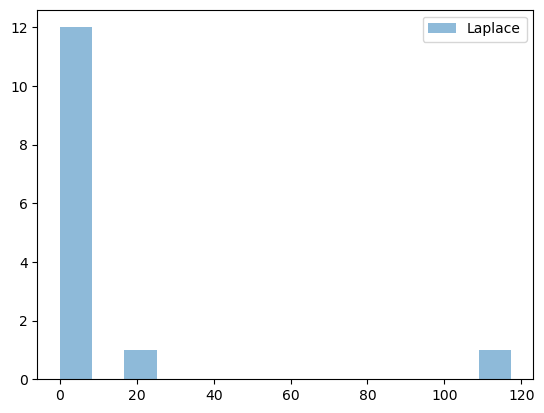

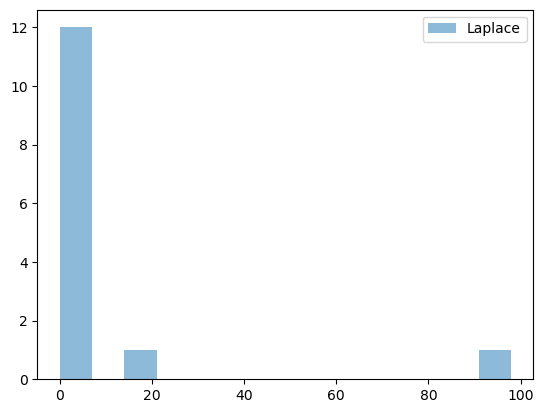

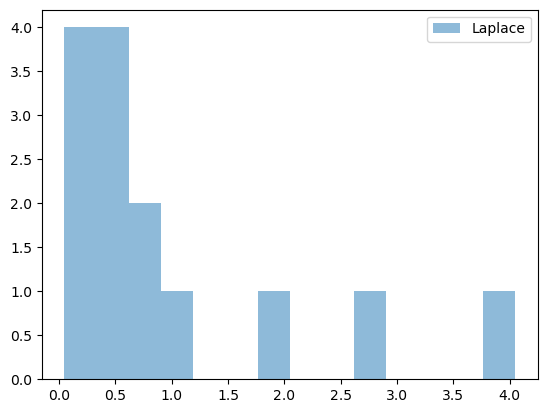

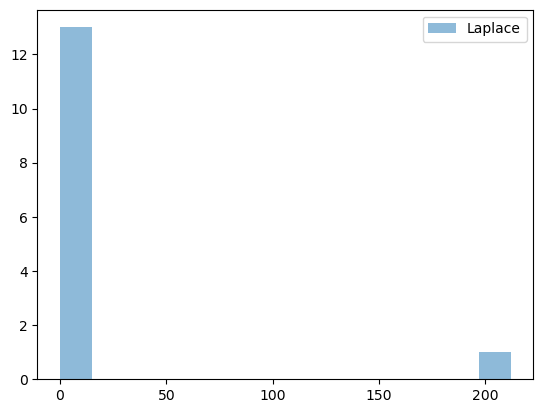

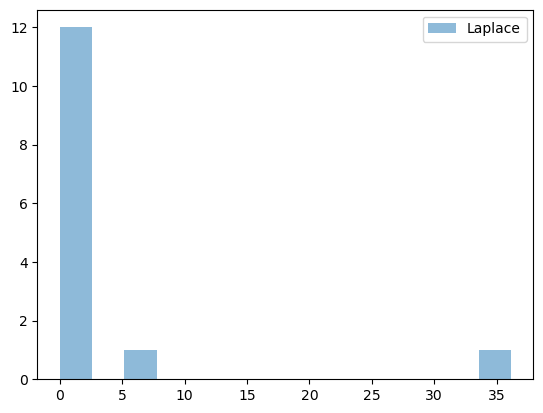

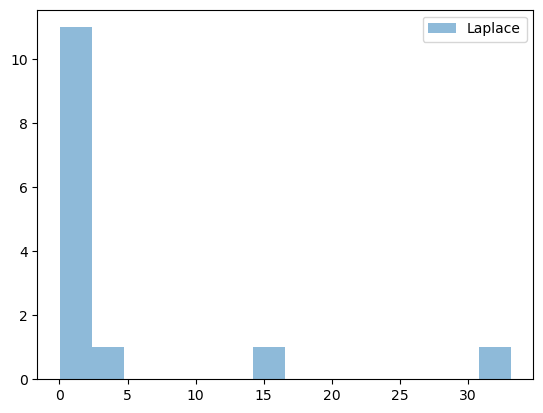

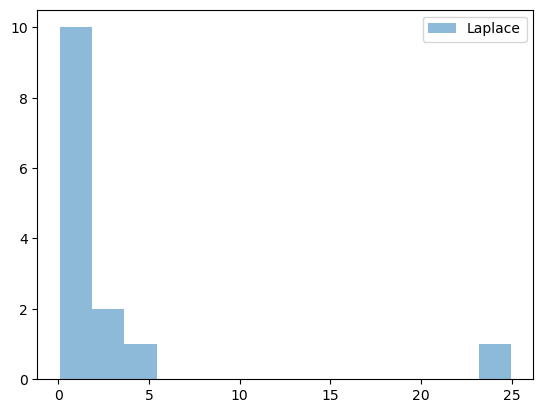

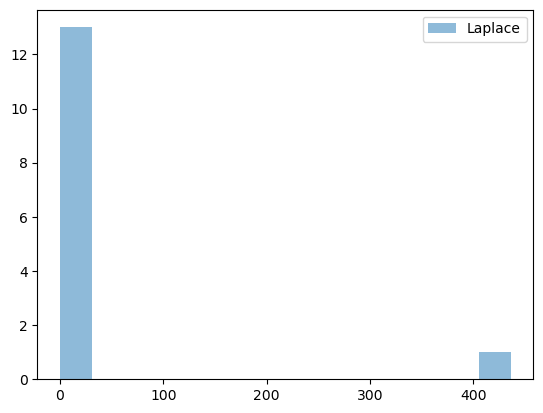

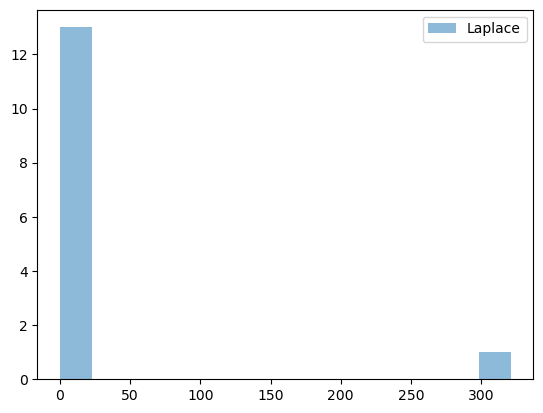

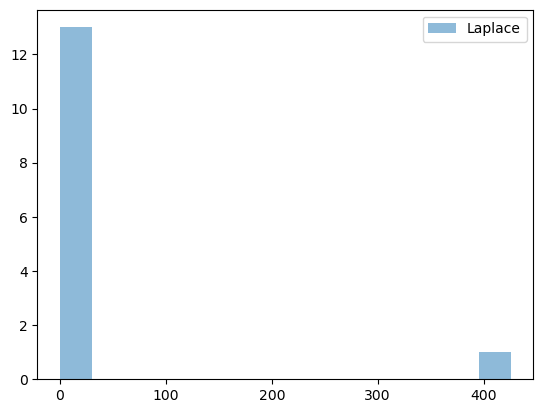

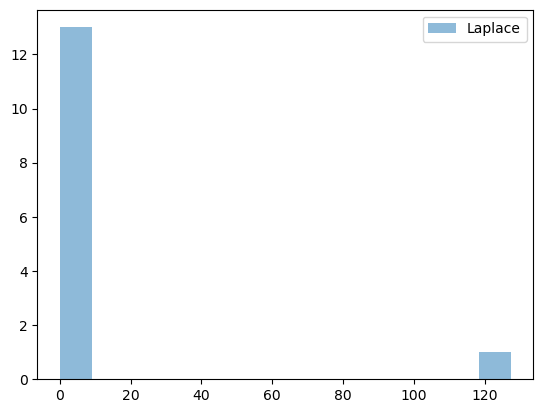

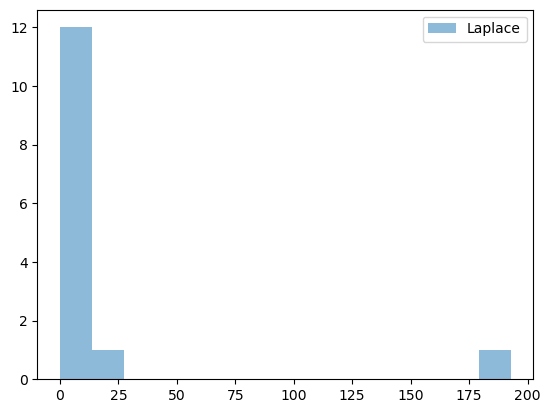

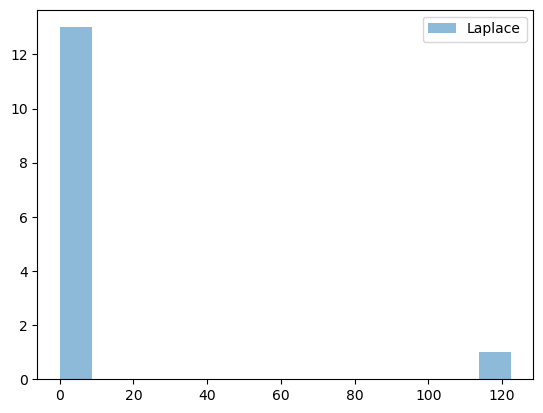

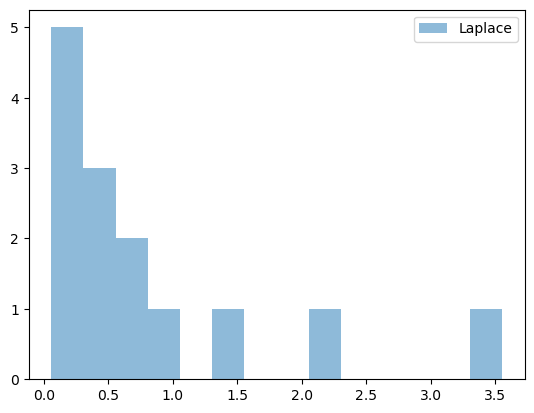

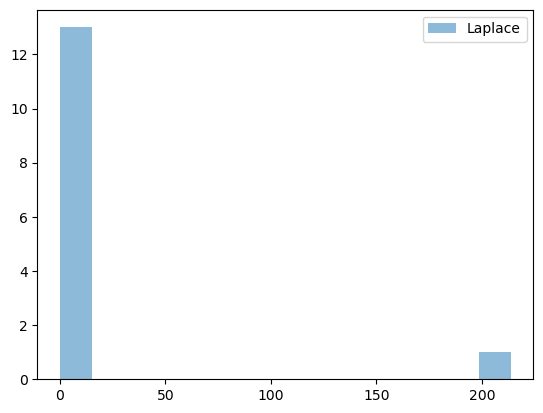

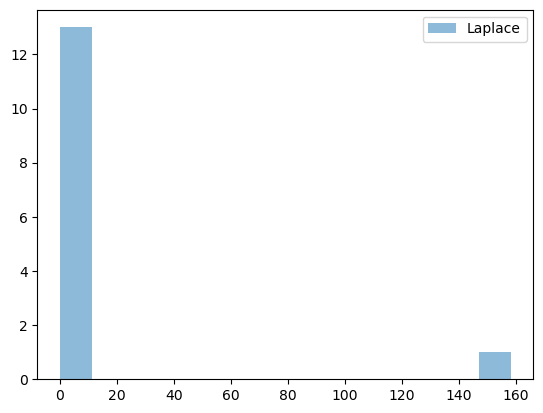

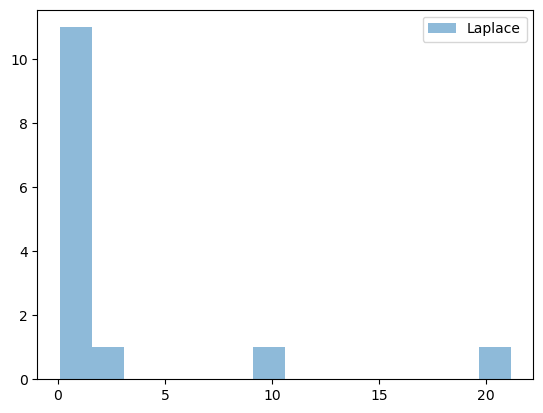

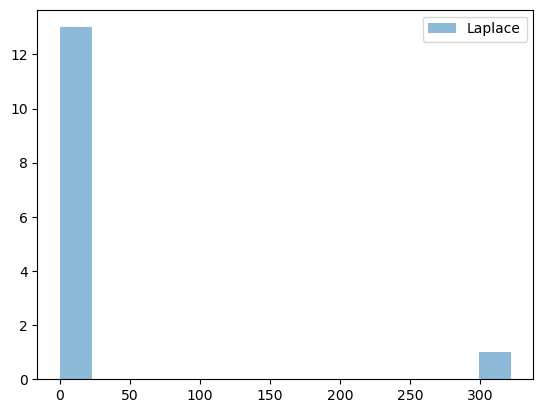

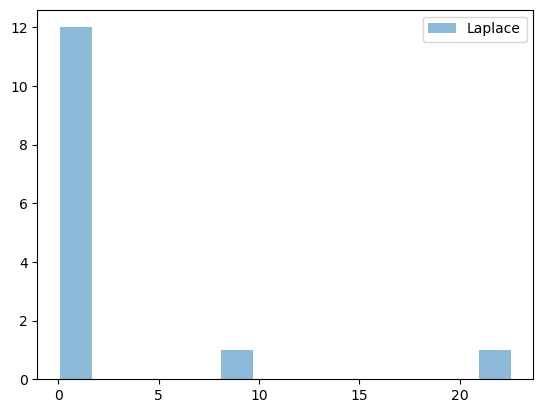

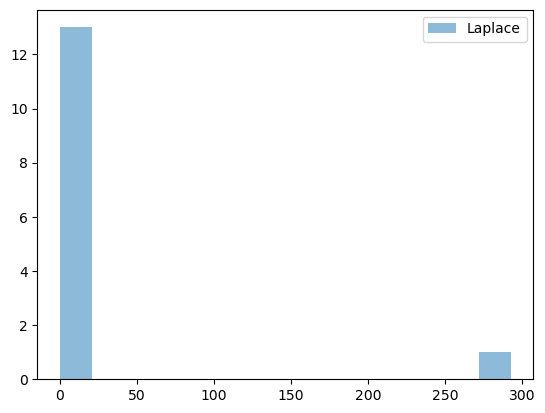

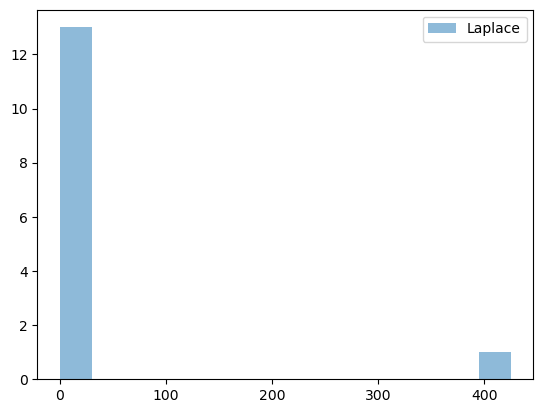

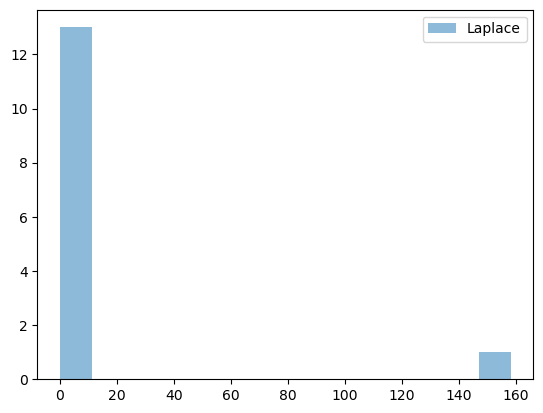

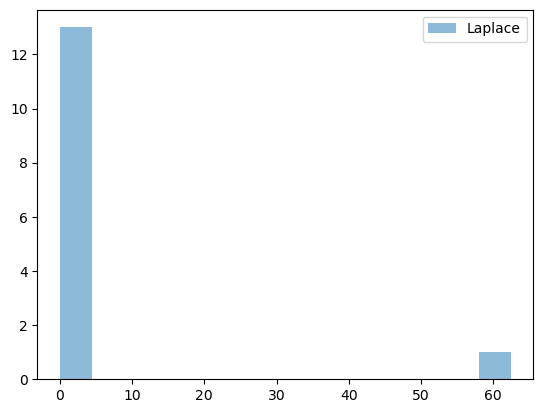

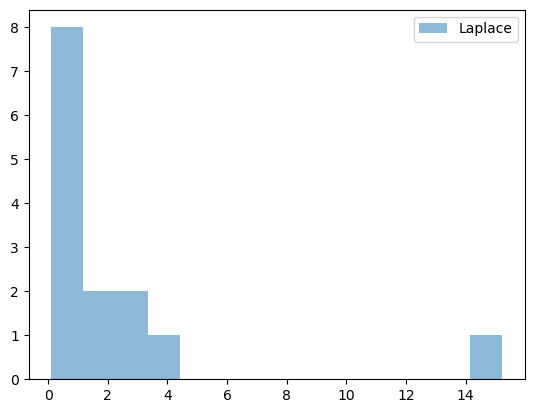

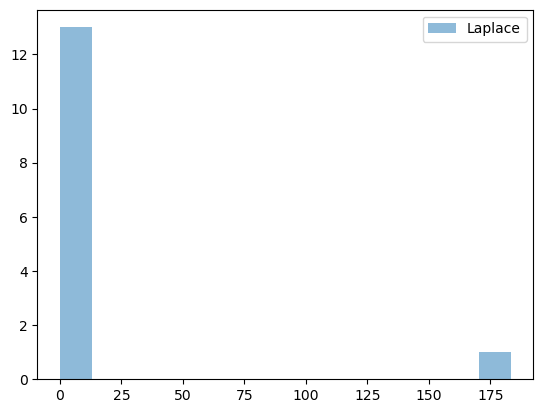

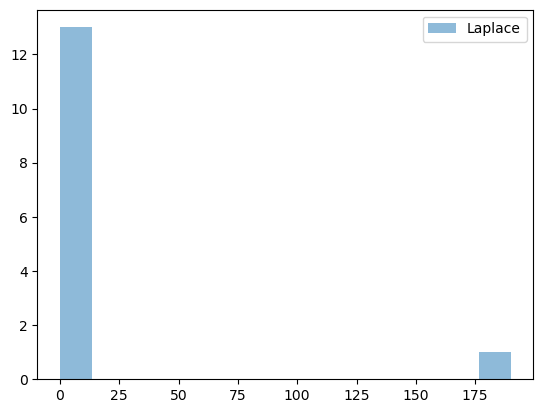

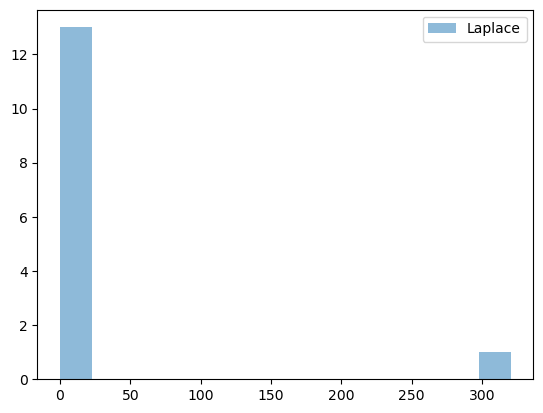

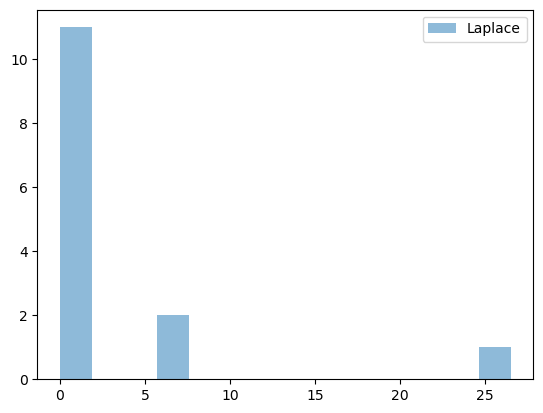

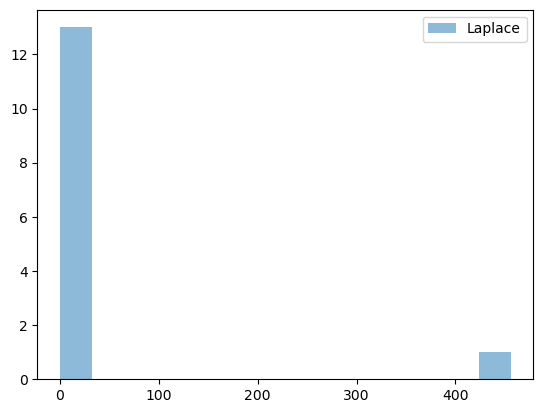

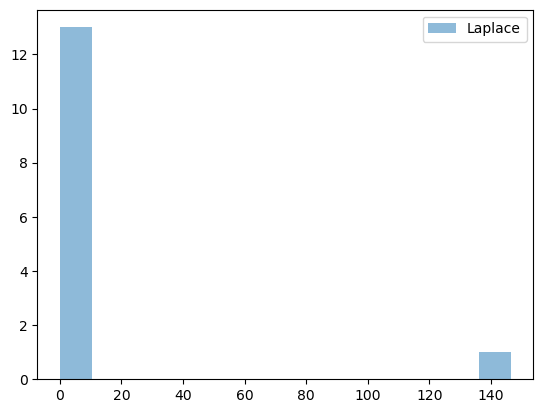

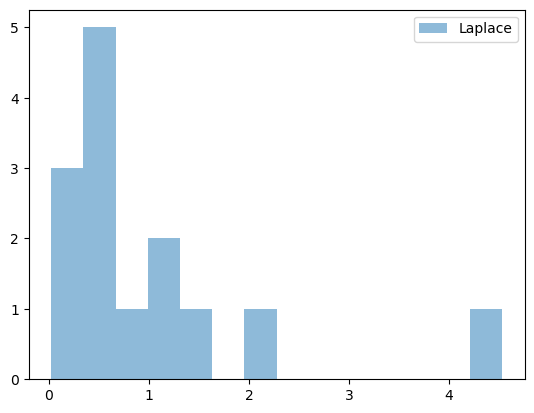

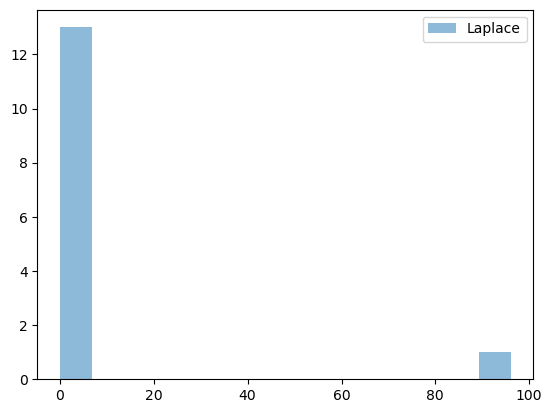

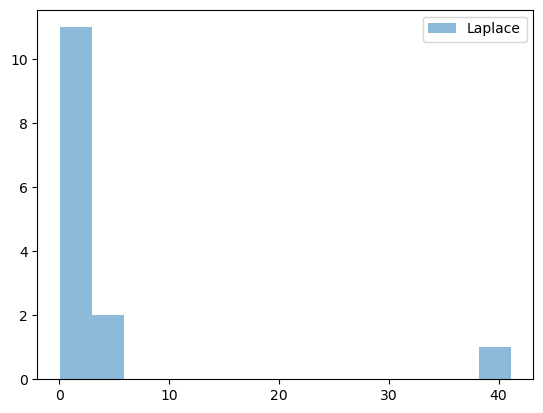

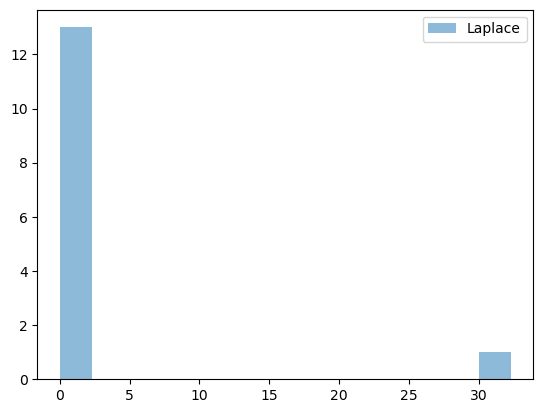

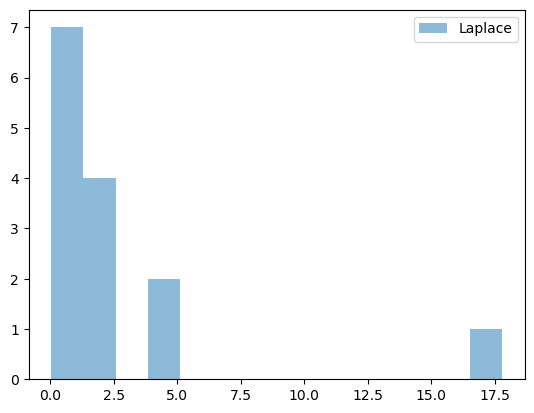

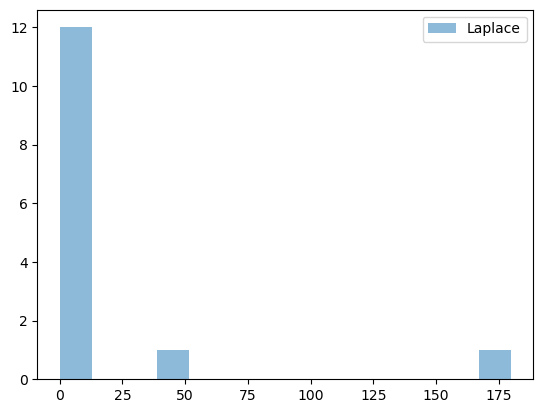

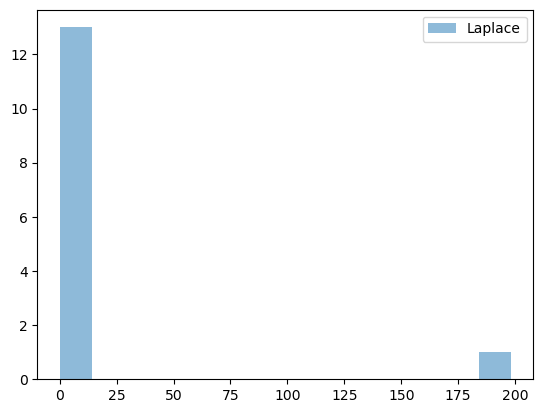

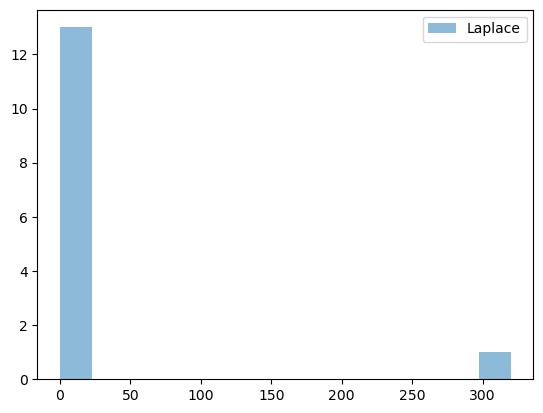

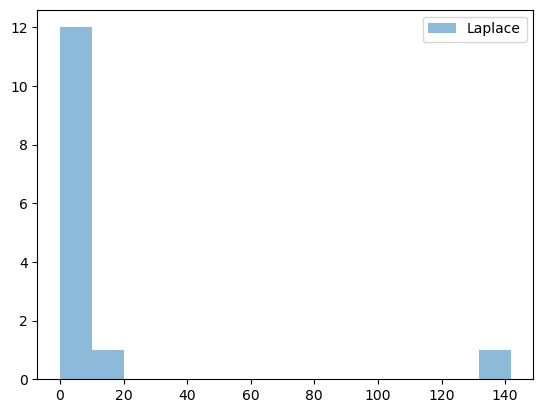

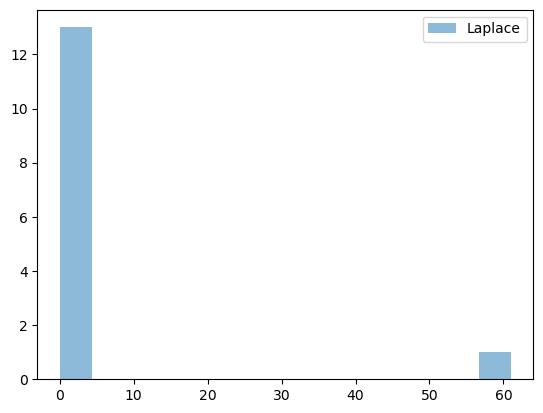

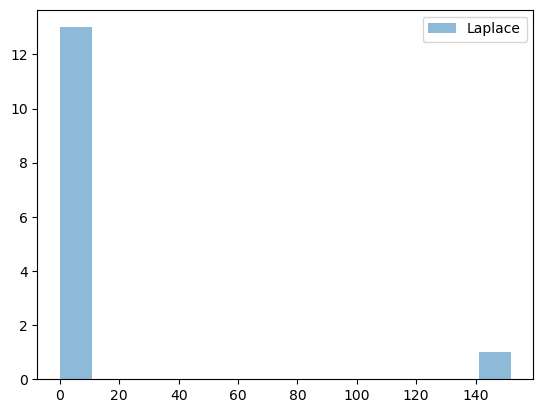

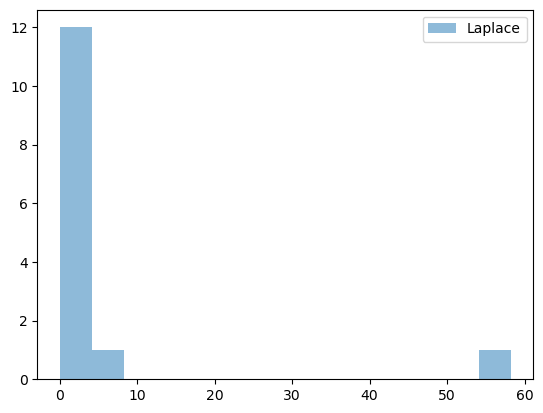

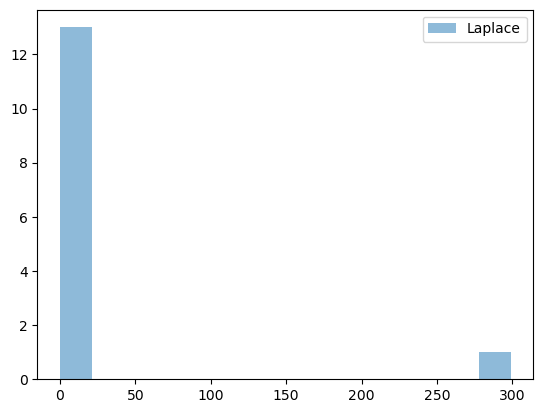

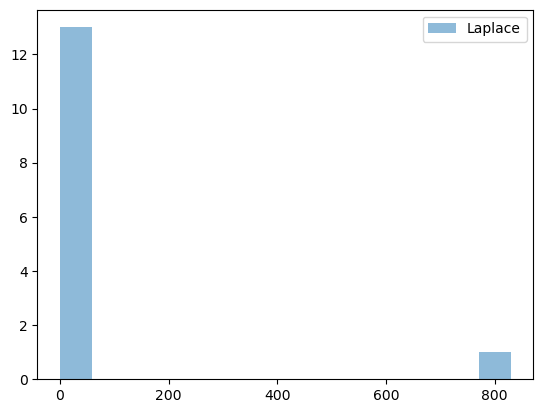

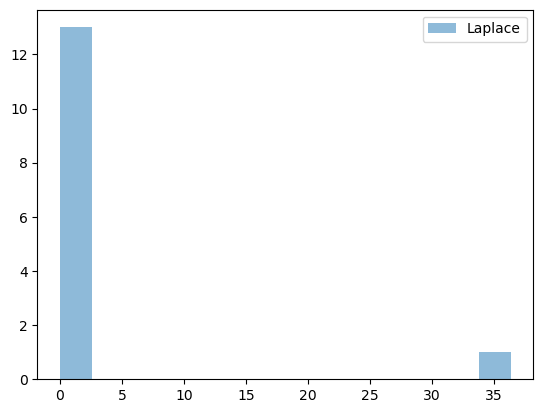

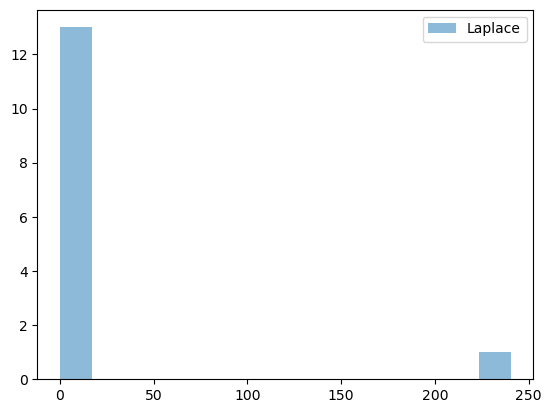

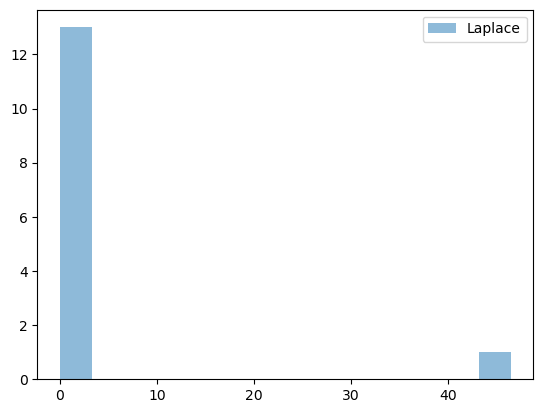

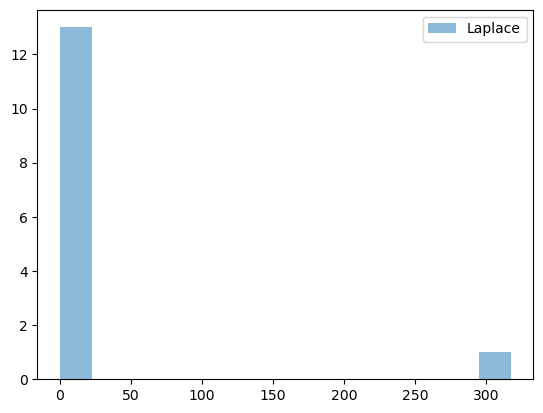

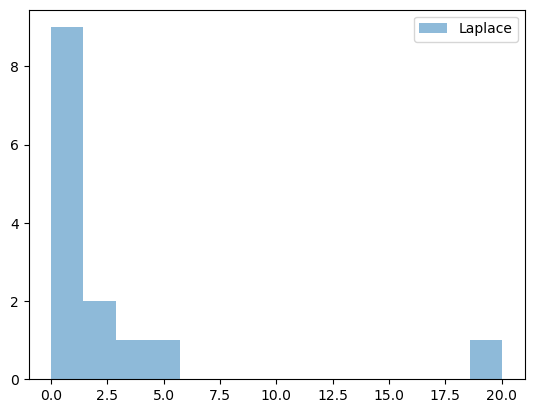

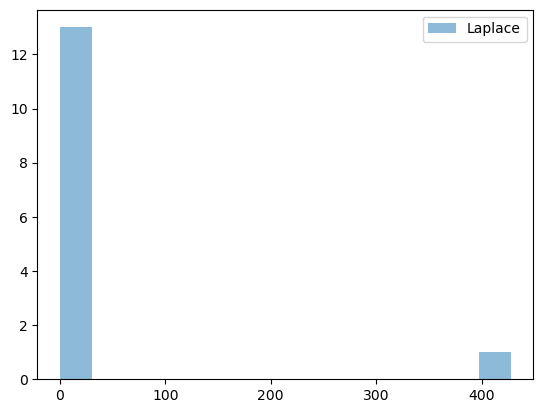

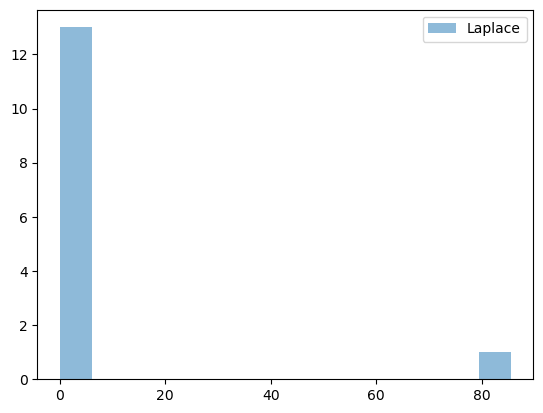

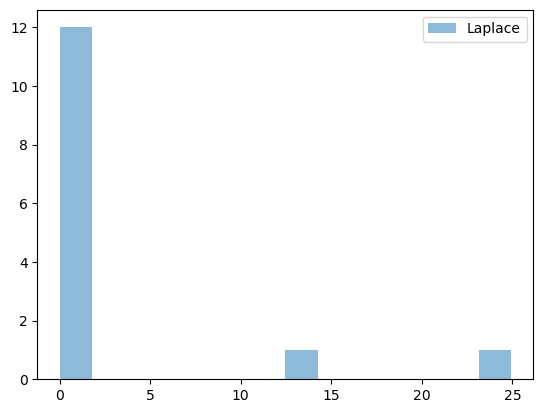

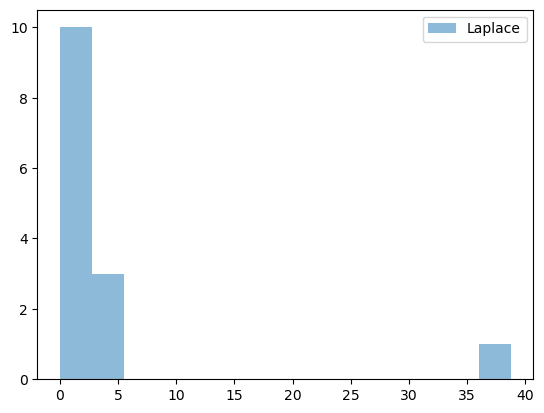

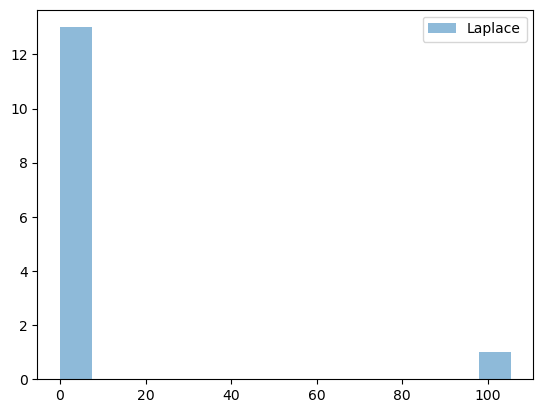

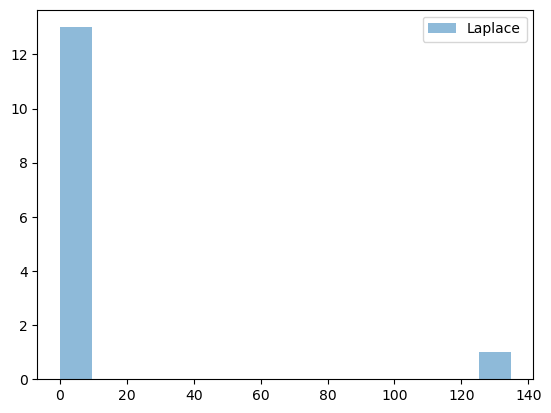

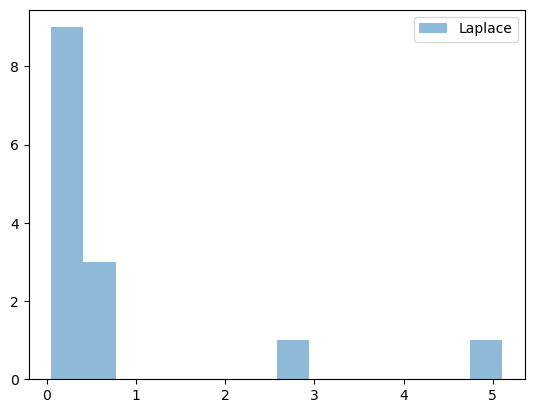

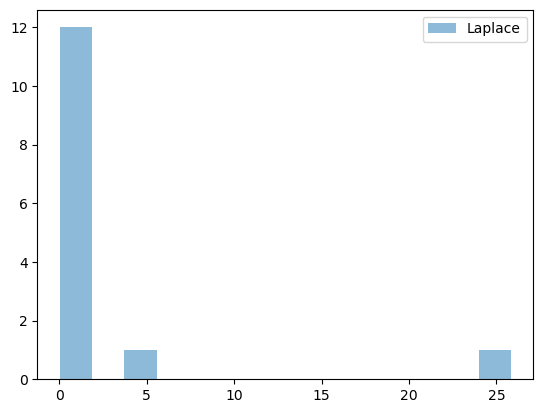

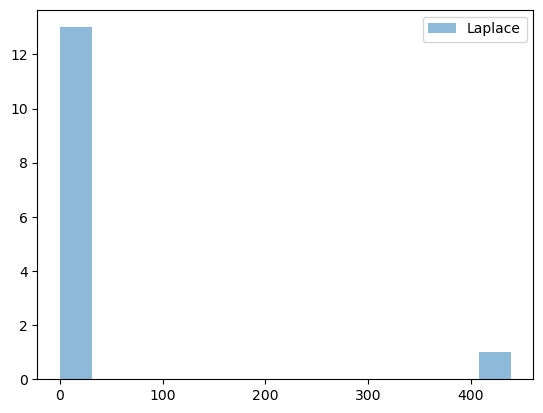

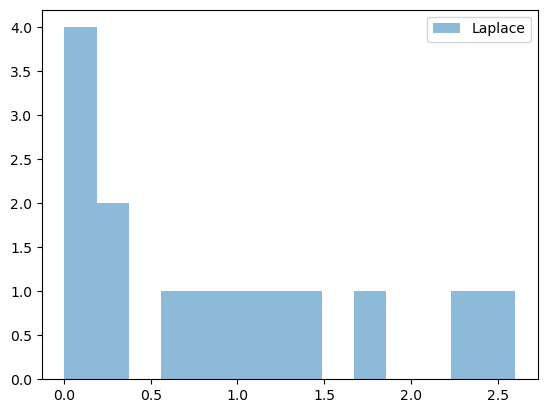

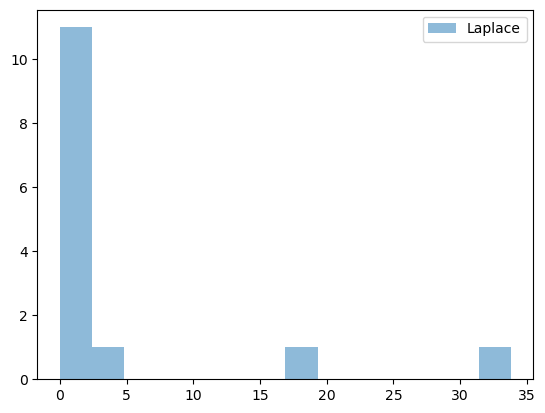

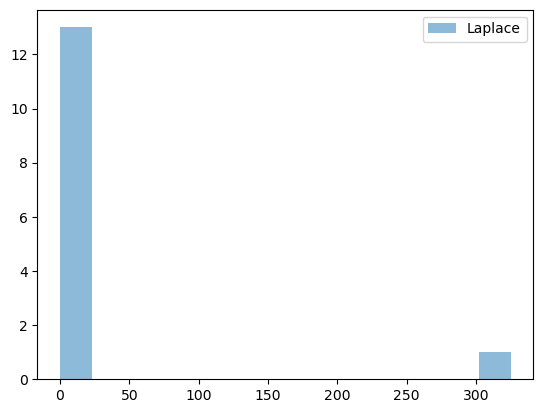

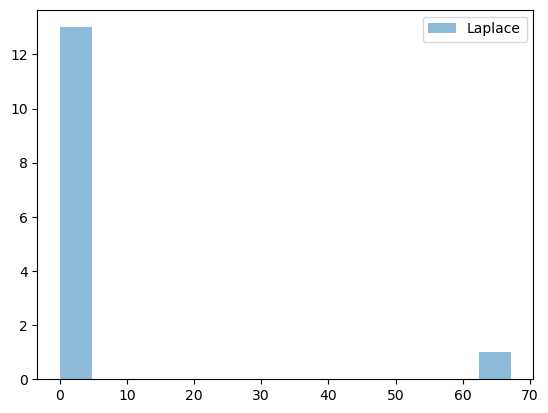

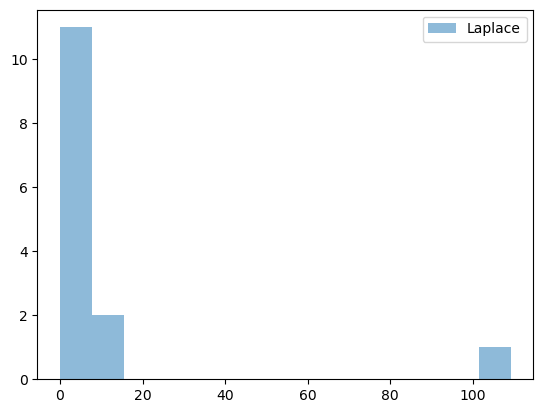

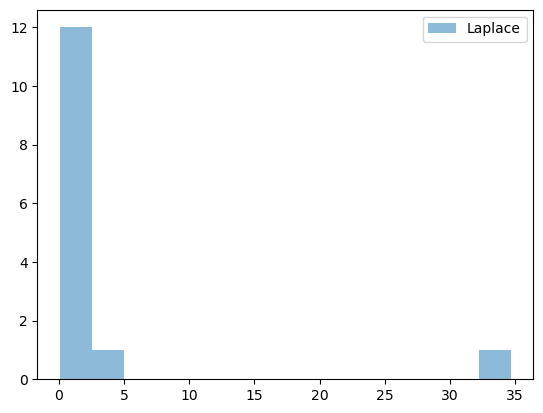

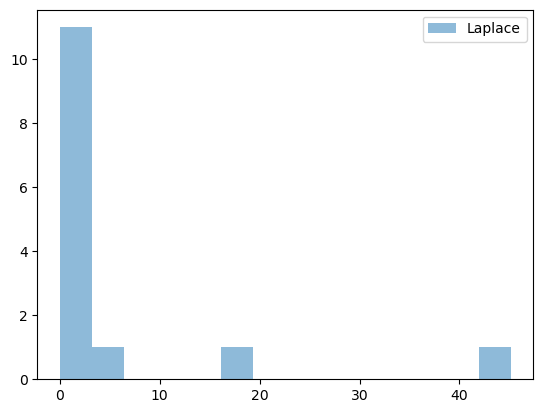

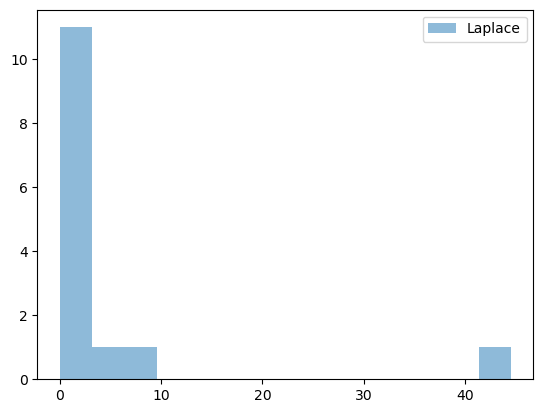

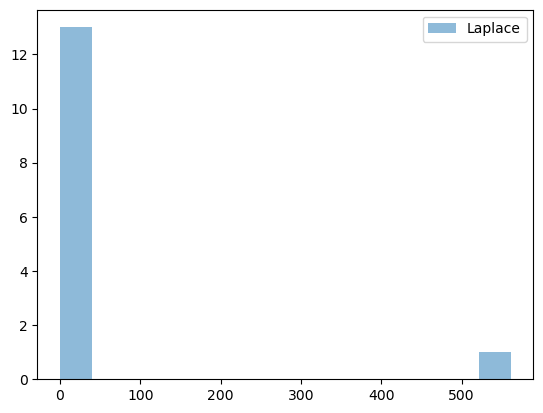

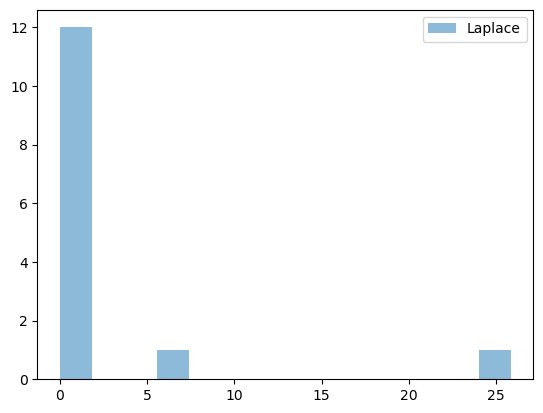

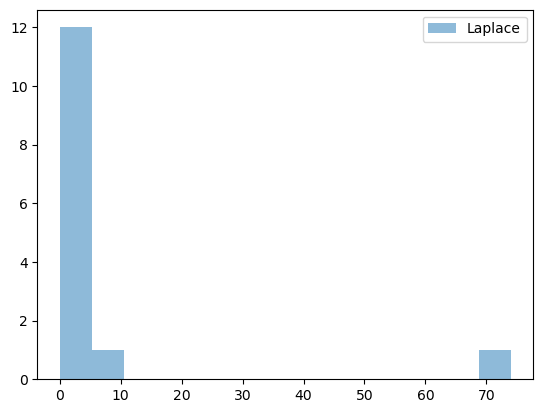

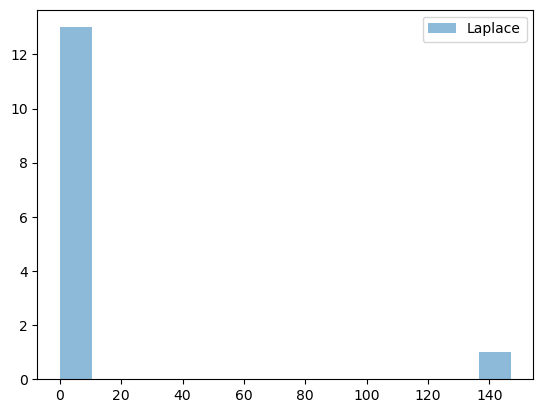

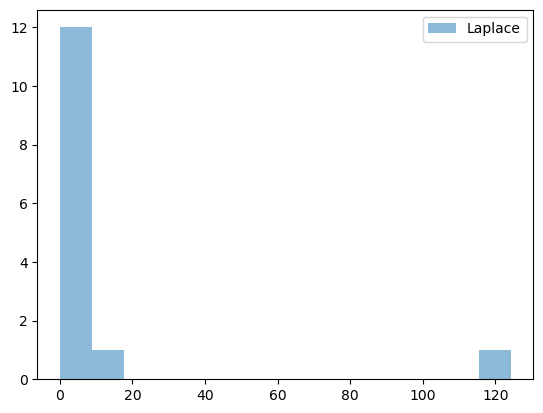

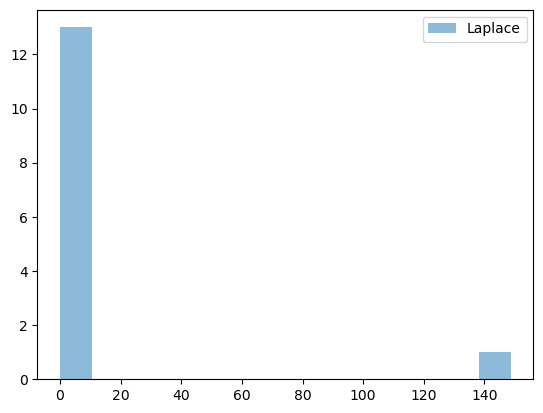

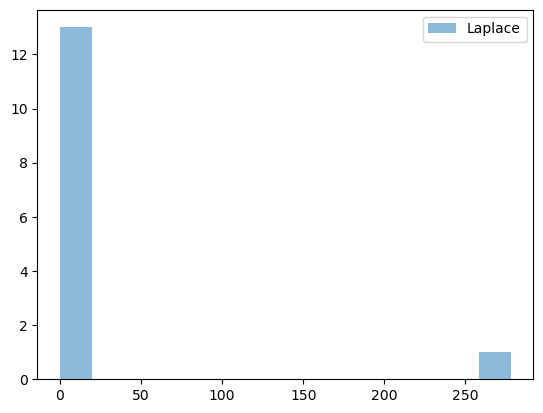

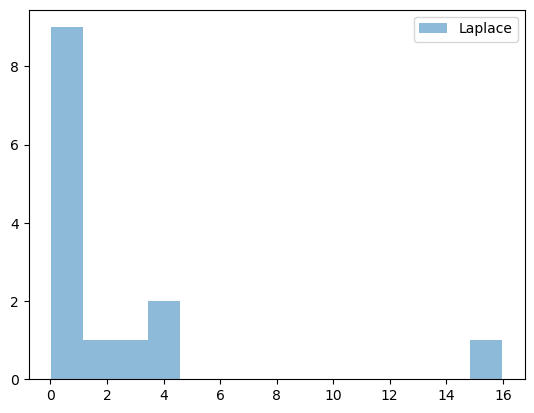

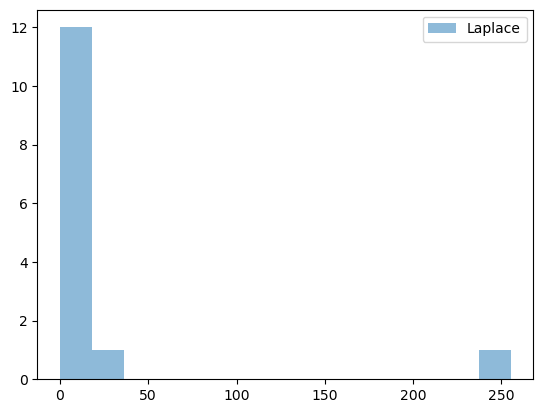

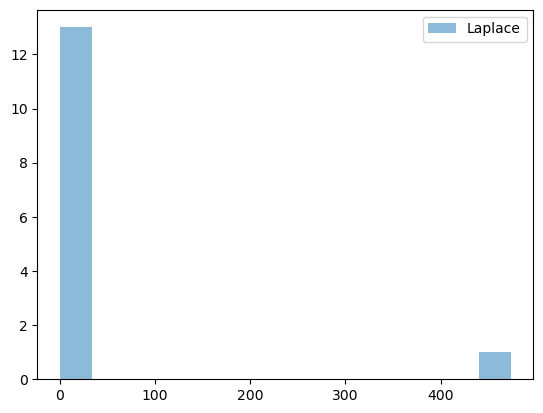

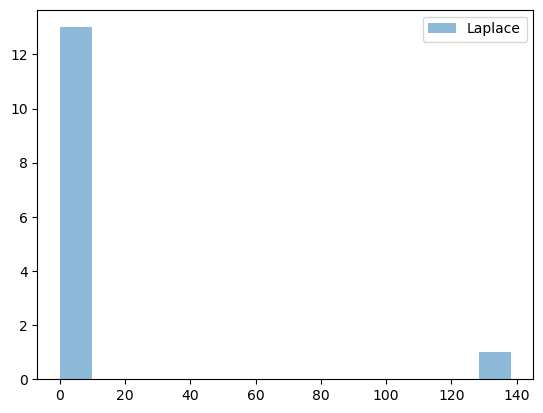

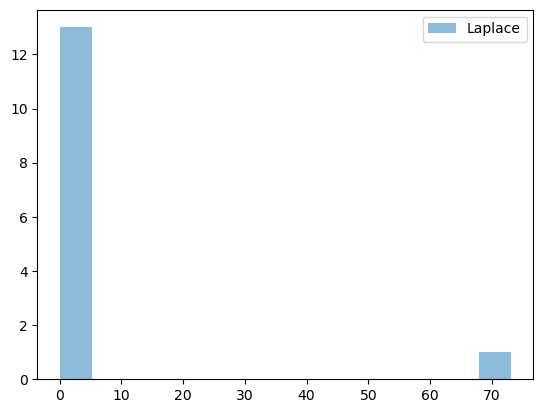

AssertionError: 

In [13]:
# TEST CASE
hist = adult['Occupation'].value_counts()
dp_results = [np.abs(dp_occupation_histogram(1.0)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/1.0) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 2
assert stats.wasserstein_distance(all_dp_results, spec) > 0

dp_results = [np.abs(dp_occupation_histogram(0.01)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/0.01) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 150
assert stats.wasserstein_distance(all_dp_results, spec) > 50

## Question 2 (10 points)

In 2-5 sentences each, answer the following:

- Argue that your solution for `dp_occupation_histogram` satisfies `epsilon`-differential privacy.
- How would your results change (in terms of accuracy) if you used sequential composition instead of parallel composition to implement `dp_occupation_histogram`, and why?
- If you partition the data by *both* occupation and age (i.e. a contingency table), would parallel composition still apply? Why or why not?
- If you partition the data by both occupation and age, what would happen to accuracy, and why?

1. I divided epsilon by the number of bins, so the algorithm satisfies epsilon-differential privacy
2. There would be more noise added in sequential composition, so the accuracy would decrease. Also, the provacy budget would accumulate if more queries were used, so the total epsilon would be the sum of esach epsilon for each queries.
3. Parallel composition would not apply correctly because Occupation and Age queries would depend on each other since the counts for different Age groups for each occupation are related, and I would need to treat all queries as independent for parallel occupation.
4.  This would increases the total privacy budget and leads to increased noise and less accuracy to the true counts.

## Question 3 (5 points)

Consider the code below, which graphs the total privacy cost of an averaging attack under (1) sequential composition and (2) advanced composition, for values of `k` between 1 and 200.

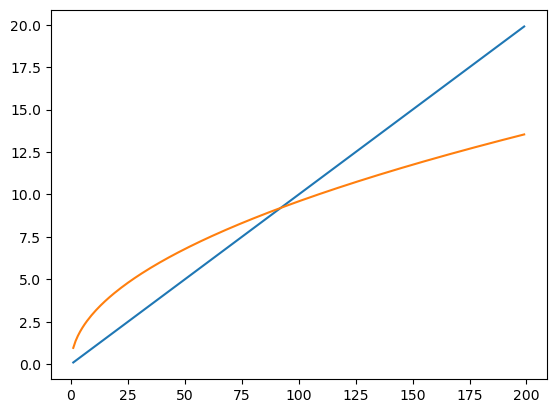

In [3]:
epsilon = .1
delta_p = 1e-5

def query():
    return len(adult_data[adult_data['Martial Status'] == 'Divorced'])

def avg_attack(k):
    return np.mean([laplace_mech(query(), 1, epsilon) for i in range(k)])
    
xs = range(1, 200)
privacy_cost_sequential = [k * epsilon for k in xs]
privacy_cost_advanced = [2 * epsilon * np.sqrt(2 * k * np.log(1/delta_p)) for k in xs]

plt.plot(xs, privacy_cost_sequential);
plt.plot(xs, privacy_cost_advanced);

In 2-5 sentences, answer the following:
- At approximately what point do the lines representing the two approaches cross? What does this mean about **which** composition technique should be used for an iterative algorithm?
- The two lines represent **different** privacy costs for the **same** algorithm. How can both be correct?

1. The lines cross at about x = 90. For values of k < 90, we should use sequetial composition and for k > 90 we should use advanced composition.
2. They can both work, but each has advantages depending on k. Sequential composition has lower privacy cost with less queries where each query is indepented, and advanced composition has less privacy cost with higher number of queries.

## Question 4 (10 points)

Consider the code below, which defines three average queries and runs them on `adult_data`, using the Laplace mechanism to provide differential privacy with $\epsilon = 1$ for each query.

In [4]:
b_capgain = 10000
b_age = 3000

epsilon = 1

def query1():
    return np.sum(adult['Capital Gain'].clip(lower=0, upper=b_capgain))

def query2():
    return len(adult[adult['Education-Num'] < 10])

def query3():
    return np.sum(adult['Age'].clip(lower=0, upper=b_age))

def my_query():
    return [query1(), query2(), query3()]

my_query()

[17145231, 14754, 1256257]

In 2-5 sentences, answer the following:
- What is the $L_1$ global sensitivity of `my_query`, and why?
- What is the $L_2$ global sensitivity of `my_query`, and why?

1. The L1 global sensitivity is 10000. Out of 1, 3000, and 10000, the output could change at maximum by 10000 when one row is modified.
2. The L2 global sensitivity is about 104.4, which is the square root of the sums of the squares of all sensitivites (root(1^2 + 3000^2 + 10000^2)).

## Question 5 (5 points)

In the cell below, write code to release the results of calling `my_query()` with differential privacy, without using sequential composition.

*Hint*: use `laplace_mech_vec`, but be careful of sensitivity!

In [6]:
sensitivity_values = [10000, 1, 3000]
def my_query_lap(epsilon):
    results = my_query()
    
    noisy_results = []
    for i, result in enumerate(results):
        noisy_results.append(laplace_mech(result, sensitivity_values[i], epsilon))
    
    return noisy_results


my_query_lap(1.0)

[17151485.791491292, 14751.380908459058, 1252432.437728211]

### Question 6 (5 points)

In the cell below, write code to release the results of `my_query()` with differential privacy, but using the Gaussian mechanism.

*Hint*: remember to use $L_2$ sensitivity

In [8]:
def my_query_gauss(epsilon, delta):
    results = my_query()
    sensitivity_values = [10000, 1, 3000]  

    noisy_results = []
    for i, result in enumerate(results):
        noisy_results.append(gaussian_mech(result, sensitivity_values[i], epsilon, delta))
    
    return noisy_results

my_query_gauss(1.0, 1e-5)

[17164943.530133847, 14759.002838085138, 1235607.133355513]